In [2]:
from tsai.all import *
import sklearn.metrics as skm
import os
import shutil
import glob
import datetime
import time
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.8.15
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.9.1+cu111
device          : 1 gpu (['NVIDIA GeForce RTX 2070 SUPER'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.92 GB
GPU memory      : [8.0] GB


### Resteaze Data

In [3]:
# Read raw PPG files as a list of dataframes and store them in a list
def read_raw_ppg_files():
    files = glob.glob('../../prof_data/resteaze/*.csv')
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df_list.append(df)
    return df_list


data = read_raw_ppg_files()
len(data)

16

In [4]:
#@title data prcessing for each dataframe

import heartpy as hp

# Bandpass Filter
from scipy.signal import butter, sosfilt, sosfreqz


def remove_extreme_values(signal, threshold):
    # Compute the absolute difference between the signal and its mean
    absolute_difference = np.abs(signal - np.mean(signal))
    # Compute the median of the absolute difference
    median_absolute_difference = np.median(absolute_difference)
    # Compute the median absolute deviation
    median_absolute_deviation = 1.4826 * median_absolute_difference
    # Compute the z-score
    z_score = 0.6745 * (absolute_difference / median_absolute_deviation)
    # Remove the extreme values
    signal = signal[z_score < threshold]
    return signal

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def butter_bandpass_filter(dat, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, dat)
    return y


def process_data(mdf):
    all_df = mdf[[
        'unixTimes', 'accelerometerX', 'accelerometerY', 'accelerometerZ',
        'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'ledGreen', 'sleep_state'
    ]]

    all_df = all_df[all_df['sleep_state'].notna()]
    all_df = all_df.interpolate()

    all_df = all_df[all_df.sleep_state != -1].reset_index()

    all_df = ((all_df + all_df.shift(-1)) / 2)[::2]

    # Binary Classification
    all_df["sleep_state"] = np.where(all_df["sleep_state"] == 0, 0, 1)

    # fill NaN values
    all_df = all_df.dropna()

    # apply bandpass filter

    fs = 25
    lowcut = 0.55
    highcut = 3.0

    all_df['ledGreen'] = butter_bandpass_filter(all_df['ledGreen'],
                                                lowcut,
                                                highcut,
                                                fs,
                                                order=3)

    # proecess segmentwise HR df


    fs = 25  # Hz
    epoch_length = 60  # seconds

    # Calculate the breathing rate for each epoch
    wd_seg, m_seg = hp.process_segmentwise(np.array(all_df['ledGreen']),
                                        sample_rate=fs,
                                        segment_width=epoch_length)

    t_wd_dict = {'segment_indices': m_seg['segment_indices']}

    df_wd = pd.DataFrame.from_dict(t_wd_dict)
    df_m = pd.DataFrame(m_seg)

    # merge the two dataframes with common column as segment_indices
    df_segmented = pd.merge(df_m, df_wd, on='segment_indices')

    # make the segment_indices as index with first value of it
    df_segmented['segment_indices'] = df_segmented['segment_indices'].apply(
        lambda x: x[0])
    df_segmented = df_segmented.set_index('segment_indices')

    # remove index name
    df_segmented.index.name = None

    tt = df_segmented

    # add new row with index 0
    tt.loc[0] = np.nan

    tt = tt.reindex(list(range(tt.index.min(),tt.index.max()+1)),fill_value='NaN')

    # merge two dataframes with common index
    pre_final = pd.merge(all_df.reset_index(),
                         tt,
                         left_index=True,
                         right_index=True)

    # select first 15000 rows
    sed_df = pre_final.astype(float)

    sed_df = sed_df[sed_df.sleep_state != -1]

    # Binary Classification
    sed_df["sleep_state"] = np.where(sed_df["sleep_state"] == 0, 0, 1)

    sed_df = sed_df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]

    # df = ((df + df.shift(-1)) / 2)[::2]

    # fill NaN values
    sed_df = sed_df.fillna(method='bfill', limit=1500).dropna()
    # remove extreme values from the signal (outliers)

    # Example usage
    filtered_ppg = remove_extreme_values(sed_df['ledGreen'].astype(float), threshold=3.0)
    filtered_bpm = remove_extreme_values(sed_df['bpm'].astype(float), threshold=3.0)
    filtered_rmssd = remove_extreme_values(sed_df['rmssd'].astype(float), threshold=3.0)
    filtered_pnn20 = remove_extreme_values(sed_df['pnn20'].astype(float), threshold=3.0)
    filtered_pnn50 = remove_extreme_values(sed_df['pnn50'].astype(float), threshold=3.0)
    filtered_hr_mad = remove_extreme_values(sed_df['hr_mad'].astype(float), threshold=3.0)
    filtered_sd1 = remove_extreme_values(sed_df['sd1'].astype(float), threshold=3.0)
    filtered_sd2 = remove_extreme_values(sed_df['sd2'].astype(float),
                                         threshold=3.0)
    filtered_accelerometerX = remove_extreme_values(sed_df['accelerometerX'].astype(float),
                                                    threshold=3.0)
    filtered_accelerometerY = remove_extreme_values(
        sed_df['accelerometerY'].astype(float), threshold=3.0)
    filtered_accelerometerZ = remove_extreme_values(sed_df['accelerometerZ'].astype(float),
                                                    threshold=3.0)
    filtered_gyroscopeX = remove_extreme_values(sed_df['gyroscopeX'].astype(float), threshold=3.0)
    filtered_gyroscopeY = remove_extreme_values(sed_df['gyroscopeY'].astype(float), threshold=3.0)
    filtered_gyroscopeZ = remove_extreme_values(
        sed_df['gyroscopeZ'].astype(float), threshold=3.0)

    sed_df['ledGreen'] = filtered_ppg
    sed_df['bpm'] = filtered_bpm
    sed_df['rmssd'] = filtered_rmssd
    sed_df['pnn20'] = filtered_pnn20
    sed_df['pnn50'] = filtered_pnn50
    sed_df['hr_mad'] = filtered_hr_mad
    sed_df['sd1'] = filtered_sd1
    sed_df['sd2'] = filtered_sd2
    sed_df['accelerometerX'] = filtered_accelerometerX
    sed_df['accelerometerY'] = filtered_accelerometerY
    sed_df['accelerometerZ'] = filtered_accelerometerZ
    sed_df['gyroscopeX'] = filtered_gyroscopeX
    sed_df['gyroscopeY'] = filtered_gyroscopeY
    sed_df['gyroscopeZ'] = filtered_gyroscopeZ

    sed_df = sed_df.dropna()

    # reset index
    sed_df = sed_df.reset_index(drop=True)

    return sed_df

In [5]:
process_data(data[-1])

ledGreen        bpm       rmssd     pnn20     pnn50  hr_mad  \
0       55.030469  75.688073  114.142768  0.857143  0.571429    60.0   
1       57.804007  75.688073  114.142768  0.857143  0.571429    60.0   
2       60.321702  75.688073  114.142768  0.857143  0.571429    60.0   
3       76.061060  75.688073  114.142768  0.857143  0.571429    60.0   
4       63.886682  75.688073  114.142768  0.857143  0.571429    60.0   
...           ...        ...         ...       ...       ...     ...   
409635  21.001679  60.945274  272.524802  0.953488  0.837209    80.0   
409636  21.064223  60.945274  272.524802  0.953488  0.837209    80.0   
409637  20.980304  60.945274  272.524802  0.953488  0.837209    80.0   
409638  20.680896  60.945274  272.524802  0.953488  0.837209    80.0   
409639  19.979985  60.945274  272.524802  0.953488  0.837209    80.0   

               sd1         sd2  accelerometerX  accelerometerY  \
0        75.592895   69.634615         3329.75          137.00   
1        75.592895   69.634615         3328.25          120.25   
2        75.592895   69.634615         3294.50          109.25   
3        75.592895   69.634615         3298.50          128.50   
4        75.592895   69.634615         3271.00          121.50   
...            ...         ...             ...             ...   
409635  191.943745  141.908494        -2197.50          166.25   
409636  191.943745  141.908494        -2195.75          166.25   
409637  191.943745  141.908494        -2191.75          163.75   
409638  191.943745  141.908494        -2191.00          158.50   
409639  191.943745  141.908494        -2187.25          156.25   

        accelerometerZ  gyroscopeX  gyroscopeY  gyroscopeZ  sleep_state  
0             -2497.75       -1.25     -153.50       84.50            0  
1             -2444.75       -8.75     -211.00       79.25            0  
2             -2432.50       25.75     -344.50       35.00            0  
3             -2511.50       54.25     -187.50       82.25            0  
4             -2497.50       46.75     -214.50       38.25            0  
...                ...         ...         ...         ...          ...  
409635         3400.50       15.25     -204.00       56.50            1  
409636         3409.75       19.00     -219.00       67.75            1  
409637         3404.75       10.25     -226.00       53.75            1  
409638         3399.00       15.25     -247.00       46.50            1  
409639         3407.00       15.00     -242.75       46.00            1  

[409640 rows x 15 columns]

In [6]:
class_map = {
    0: 'WK',  # wake
    1: 'SL',  # sleep
}
class_map

{0: 'WK', 1: 'SL'}

# Filters and transforms

## TSData preparation

## Data from 3d array

In [7]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

metrics = [accuracy, Precision(), Recall(), F1Score()]


def train_and_evaluate_it(X, y, splits, bs, lr, epochs):
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train,
                                   dsets.valid,
                                   bs=bs,
                                   batch_tfms=[TSStandardize()],
                                   num_workers=0)
    # model = build_ts_model(InceptionTimePlus, dls=dls, **{'fc_dropout': 0.5})
    model = build_ts_model(InceptionTimePlus, dls=dls)
    learn = ts_learner(dls, model, metrics=metrics, cbs=ShowGraph())
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs, lr_max=lr)

    # Get predictions
    dls = learn.dls
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(
        dl=valid_dl, with_decoded=True)

    # Plot confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    # plot hypnogram of the predictions and the targets
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(valid_preds, label='Predictions')
    ax.plot(valid_targets, label='Targets')
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sleep Stage')
    ax.set_title('Validation Predictions vs Targets')
    plt.show()

def reshapper(X, y):
    # selecting sequences range
    X = X[0:(len(X) - len(X) % 1500)]
    y = y[0:(len(y) - len(y) % 1500)]

    # reshape the data to tsai format
    X = X.reshape(-1, 1500, 14)
    X = X.transpose(0, 2, 1)
    y = y.reshape(-1, 1500)
    y = (y.sum(axis=1) // 1500).reshape(-1, 1).flatten()

    return X, y

def get_train_valid_splits(data):

    temp_X_y_list = []

    for curr in data:

        # scaling and encoding
        scaler = StandardScaler()
        le = LabelEncoder()

        # select features and target for training and validation

        # select all other datafrmes from data list except the current one
        l = [process_data(df) for df in data if df is not curr]

        # concatenate all dataframes
        temp_df = pd.concat(l).reset_index(drop=True)

        temp_vl = process_data(curr).reset_index(drop=True)

        train_df = temp_df[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]
        valid_df = temp_vl[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]

        X_train = scaler.fit_transform(train_df.drop('sleep_state', axis=1))
        X_valid = scaler.transform(valid_df.drop('sleep_state', axis=1))

        y_train = le.fit_transform(train_df['sleep_state'])
        y_valid = le.transform(valid_df['sleep_state'])

        # reshape the data to tsai format
        X_train, y_train = reshapper(X_train, y_train)
        X_valid, y_valid = reshapper(X_valid, y_valid)

        display(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
        label_counts = collections.Counter(y_train)
        print('Counts by label:', dict(label_counts))
        print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

        X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
        temp_X_y_list.append((X, y, splits))
    
    return temp_X_y_list

In [10]:
train_valid_splits = get_train_valid_splits(data)

(3639, 14, 1500)

(3639,)

(272, 14, 1500)

(272,)

Counts by label: {0: 1172, 1: 2467}
Naive Accuracy: 67.79%


(3774, 14, 1500)

(3774,)

(137, 14, 1500)

(137,)

Counts by label: {0: 1235, 1: 2539}
Naive Accuracy: 67.28%


(3651, 14, 1500)

(3651,)

(261, 14, 1500)

(261,)

Counts by label: {0: 1139, 1: 2512}
Naive Accuracy: 68.80%


(3681, 14, 1500)

(3681,)

(230, 14, 1500)

(230,)

Counts by label: {0: 1206, 1: 2475}
Naive Accuracy: 67.24%


(3771, 14, 1500)

(3771,)

(141, 14, 1500)

(141,)

Counts by label: {0: 1157, 1: 2614}
Naive Accuracy: 69.32%


(3689, 14, 1500)

(3689,)

(223, 14, 1500)

(223,)

Counts by label: {0: 1050, 1: 2639}
Naive Accuracy: 71.54%


(3560, 14, 1500)

(3560,)

(351, 14, 1500)

(351,)

Counts by label: {0: 1218, 1: 2342}
Naive Accuracy: 65.79%


(3625, 14, 1500)

(3625,)

(287, 14, 1500)

(287,)

Counts by label: {0: 1169, 1: 2456}
Naive Accuracy: 67.75%


(3618, 14, 1500)

(3618,)

(294, 14, 1500)

(294,)

Counts by label: {0: 1177, 1: 2441}
Naive Accuracy: 67.47%


(3656, 14, 1500)

(3656,)

(256, 14, 1500)

(256,)

Counts by label: {0: 1113, 1: 2543}
Naive Accuracy: 69.56%


(3573, 14, 1500)

(3573,)

(339, 14, 1500)

(339,)

Counts by label: {0: 1191, 1: 2382}
Naive Accuracy: 66.67%


(3601, 14, 1500)

(3601,)

(311, 14, 1500)

(311,)

Counts by label: {0: 1202, 1: 2399}
Naive Accuracy: 66.62%


(3709, 14, 1500)

(3709,)

(203, 14, 1500)

(203,)

Counts by label: {0: 1220, 1: 2489}
Naive Accuracy: 67.11%


(3721, 14, 1500)

(3721,)

(191, 14, 1500)

(191,)

Counts by label: {0: 1130, 1: 2591}
Naive Accuracy: 69.63%


(3776, 14, 1500)

(3776,)

(135, 14, 1500)

(135,)

Counts by label: {0: 1212, 1: 2564}
Naive Accuracy: 67.90%


(3639, 14, 1500)

(3639,)

(273, 14, 1500)

(273,)

Counts by label: {0: 1126, 1: 2513}
Naive Accuracy: 69.06%


## Dataloaders

In [8]:
# archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}),
#          (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}),
#          (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
#          (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

# results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
# for i, (arch, k) in enumerate(archs):
#     model = build_ts_model(arch, dls=dls, **k)
#     print(model.__class__.__name__)
#     learn = ts_learner(dls, model,  metrics=[accuracy, Precision(), Recall(), F1Score()])
#     start = time.time()
#     learn.fit_one_cycle(30, 1e-3)
#     elapsed = time.time() - start
#     vals = learn.recorder.values[-1]
#     results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
#     results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
#     clear_output()
#     display(results)

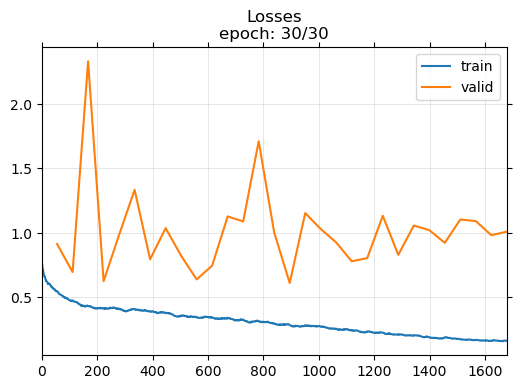

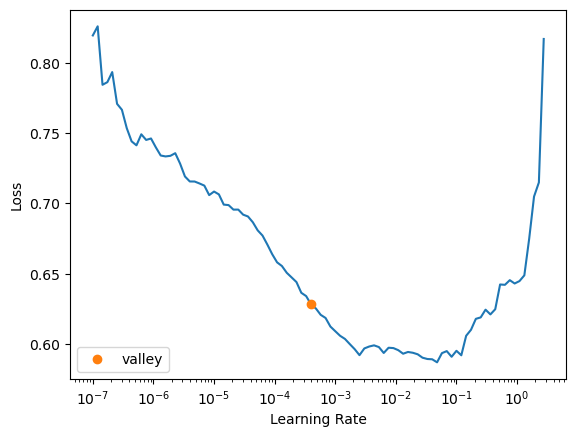

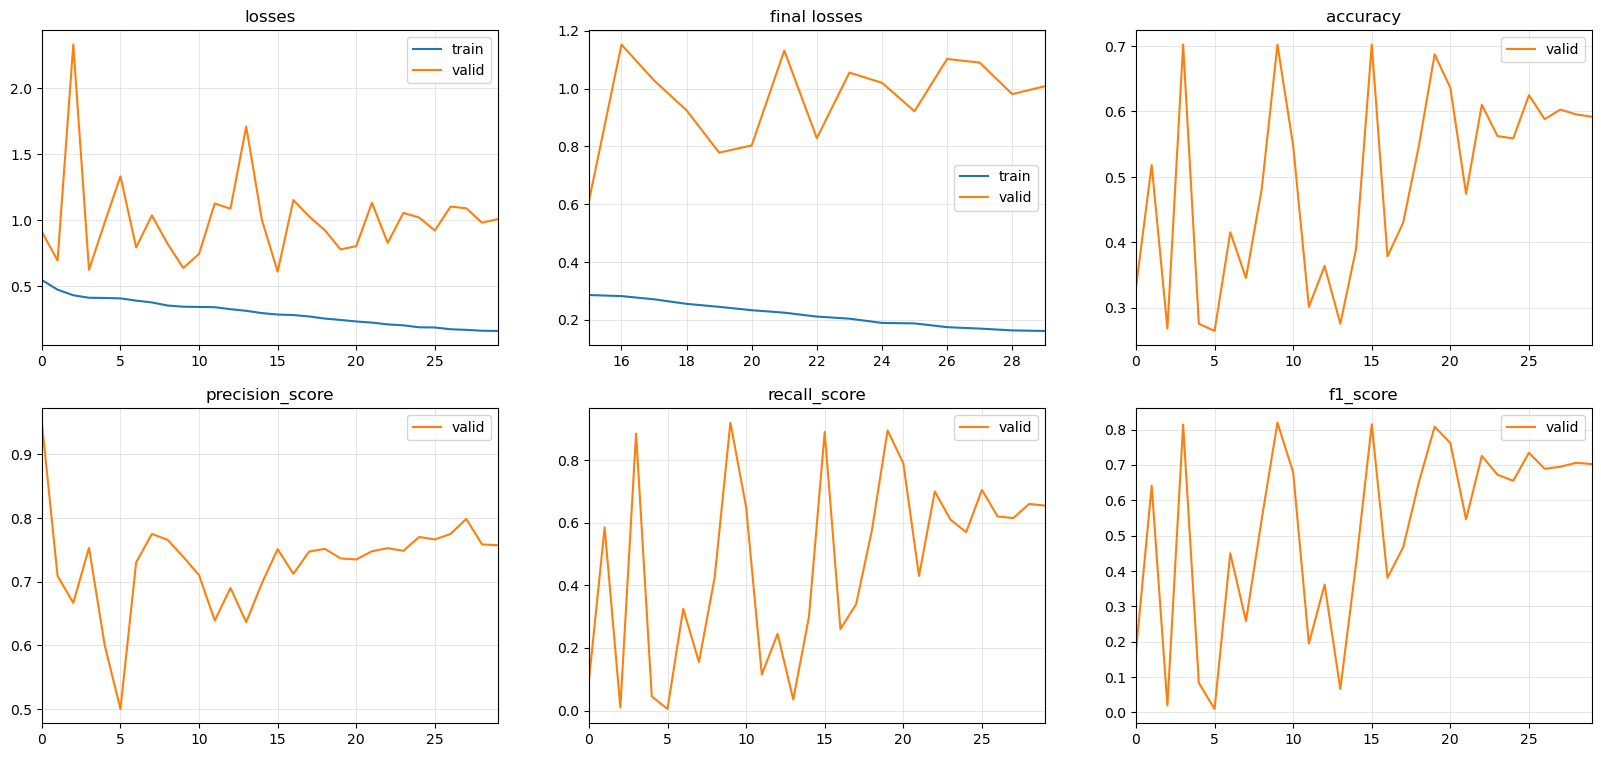

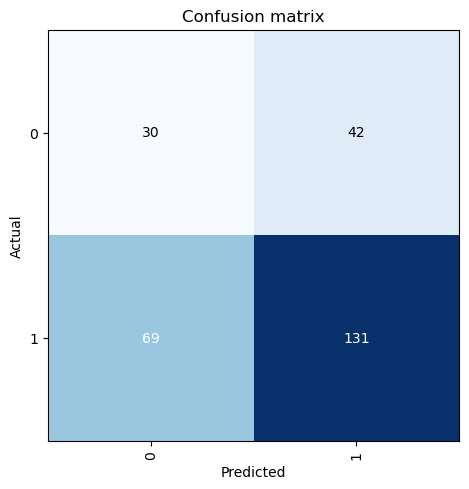

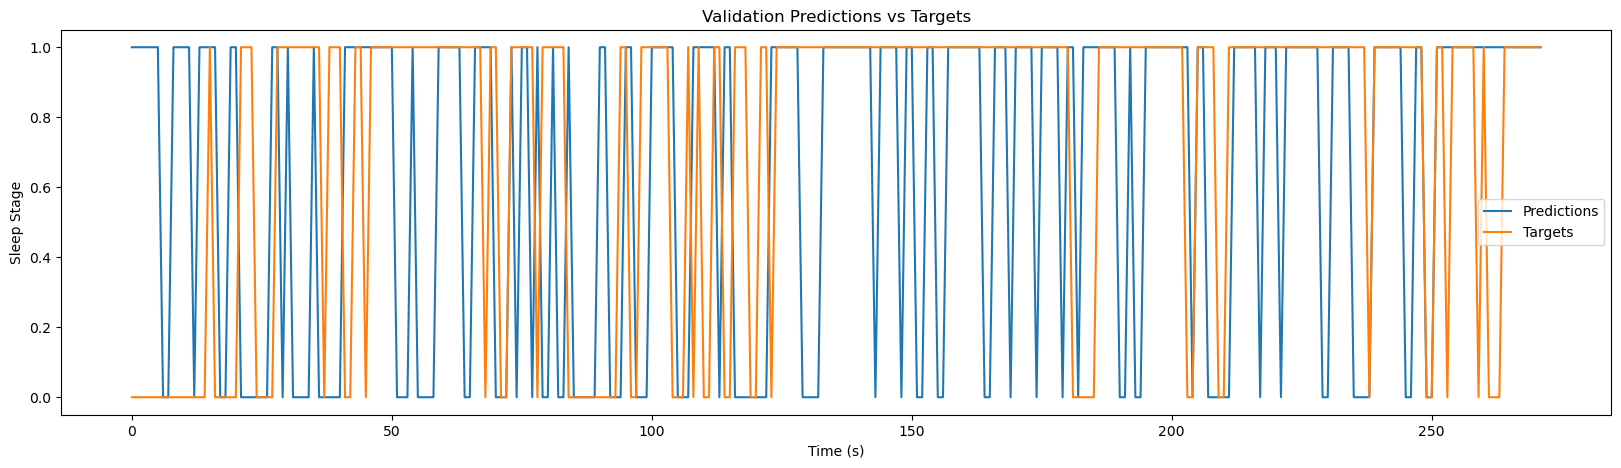

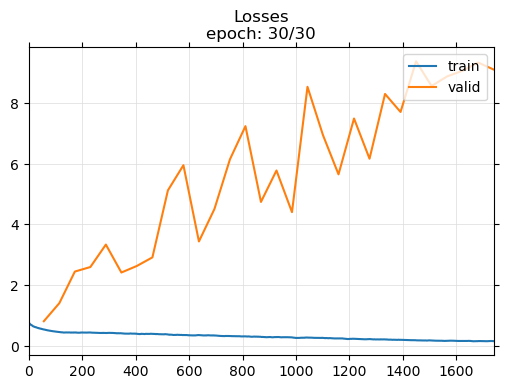

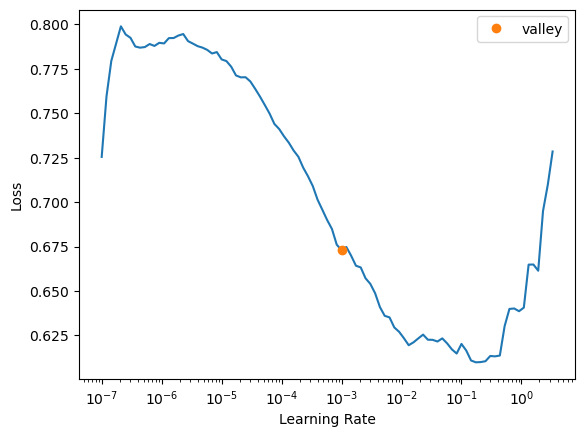

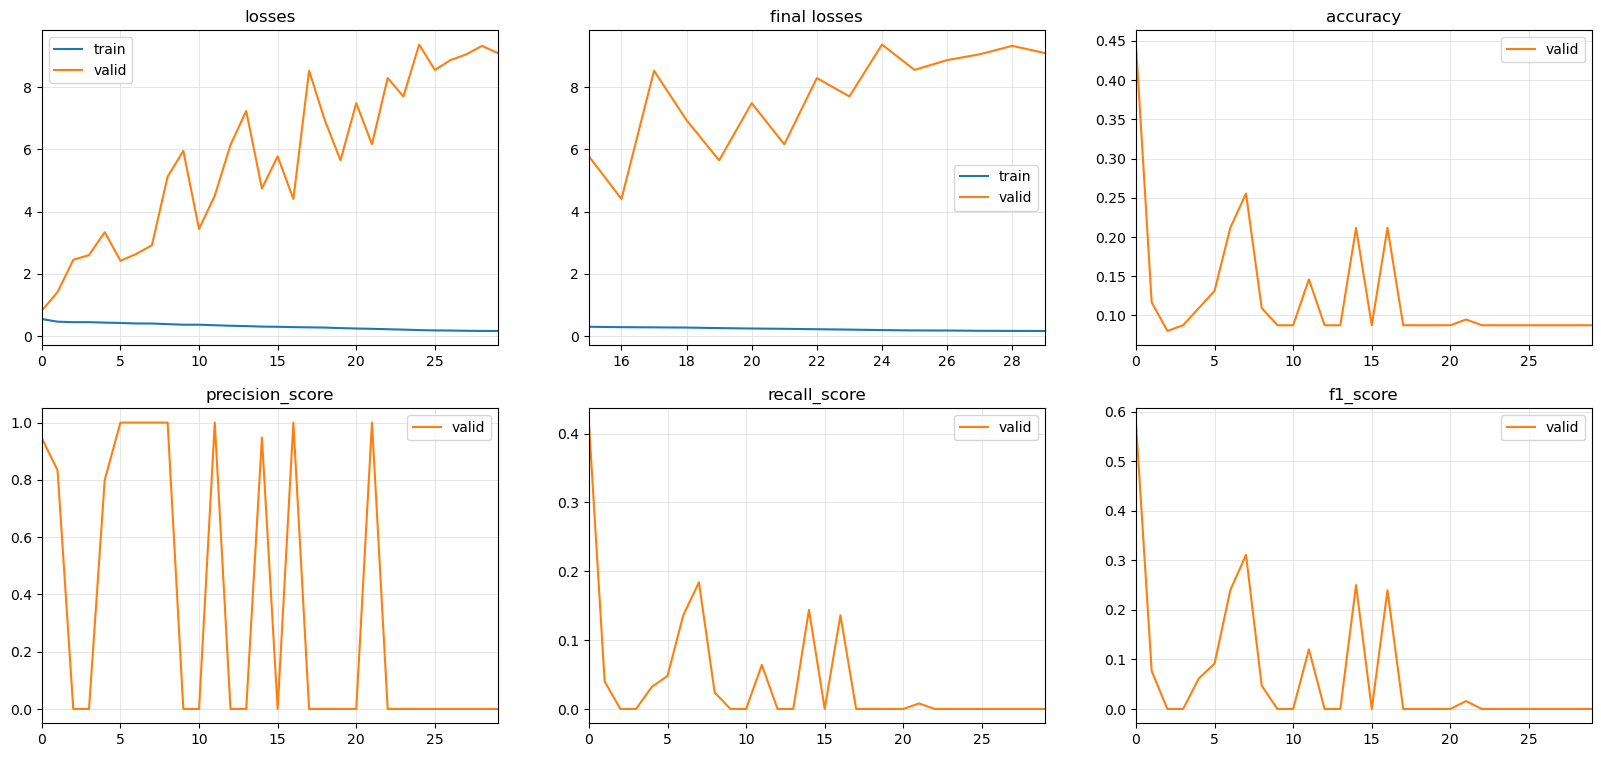

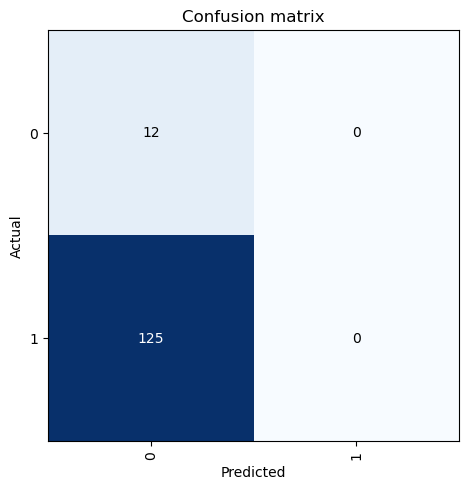

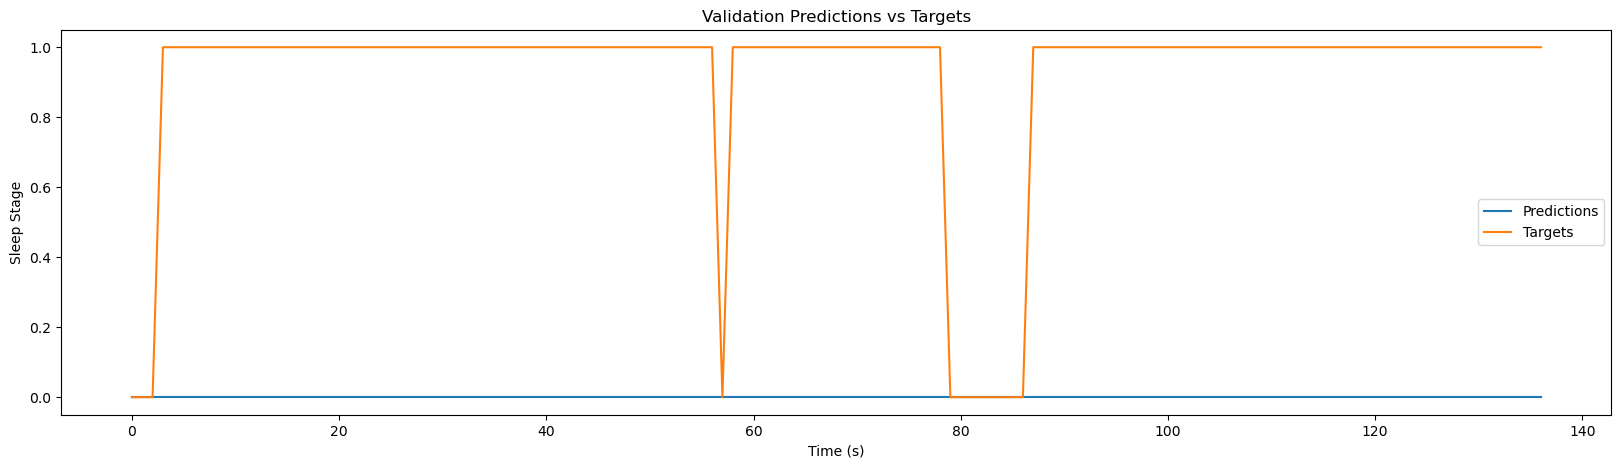

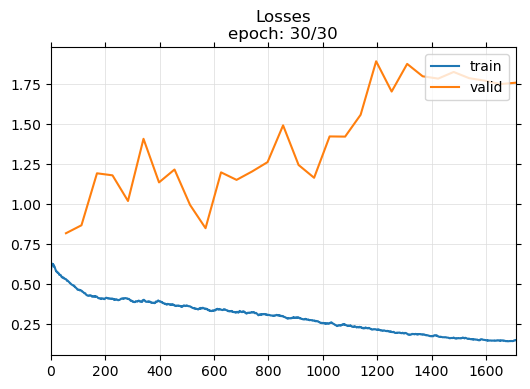

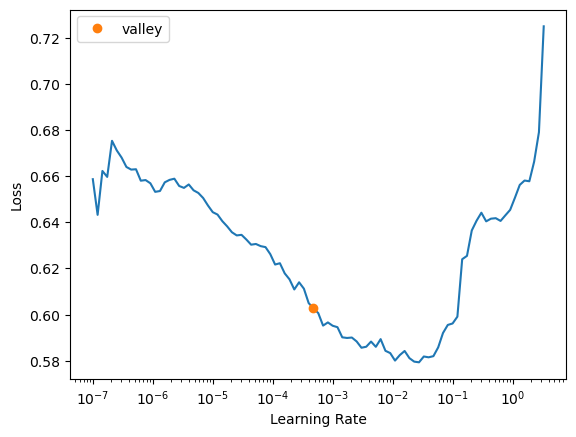

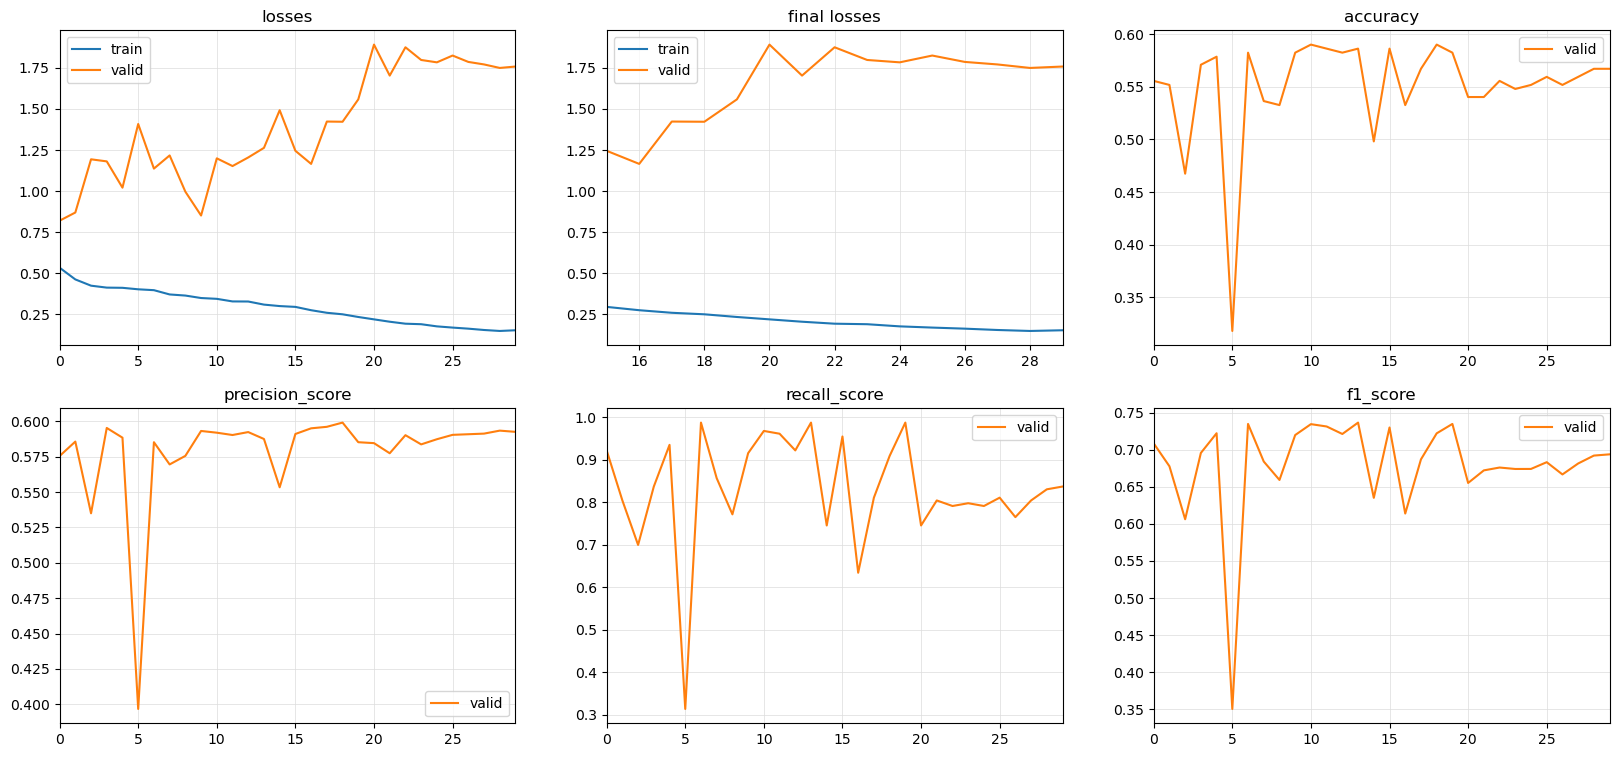

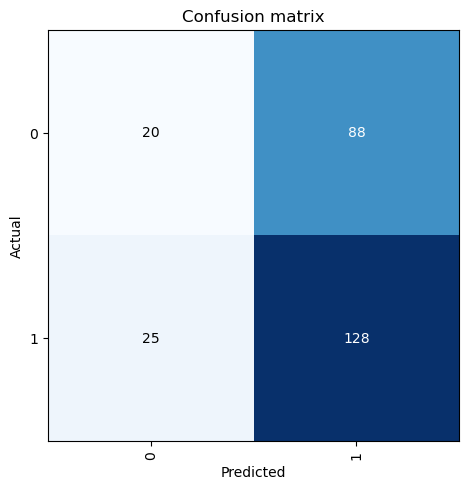

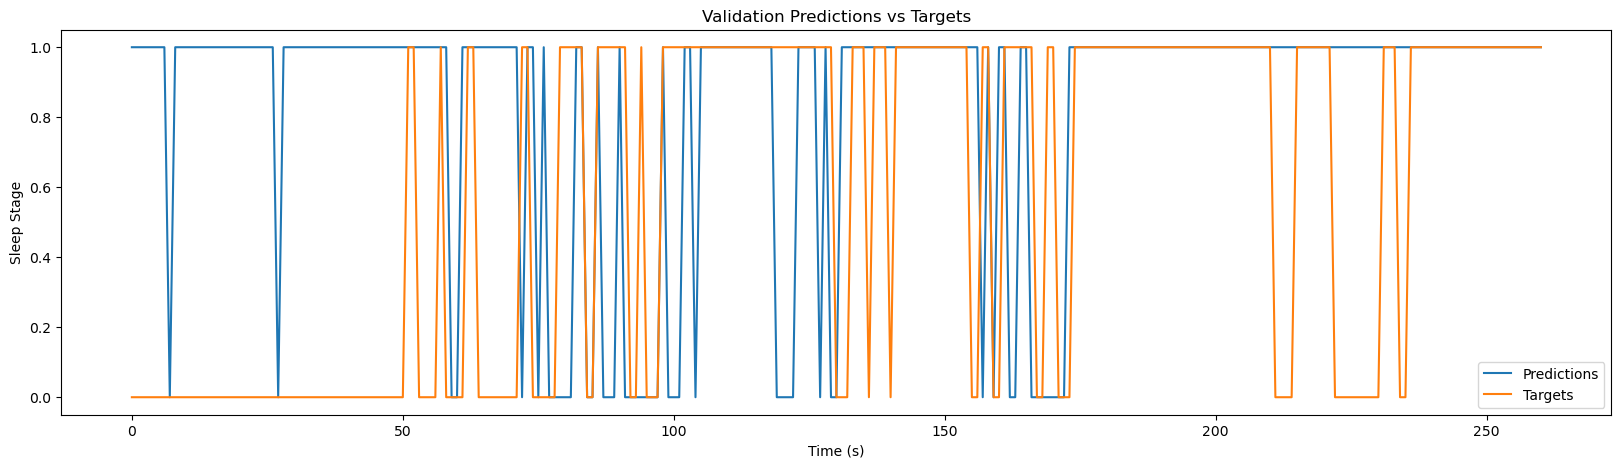

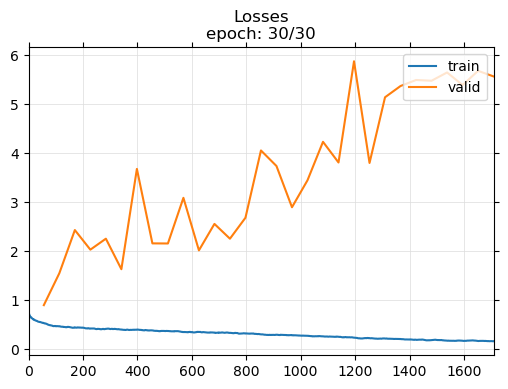

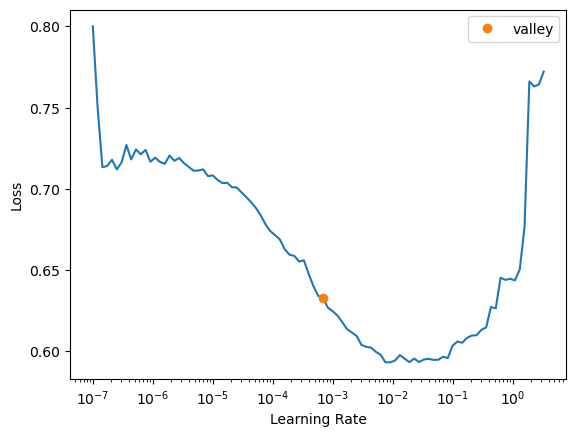

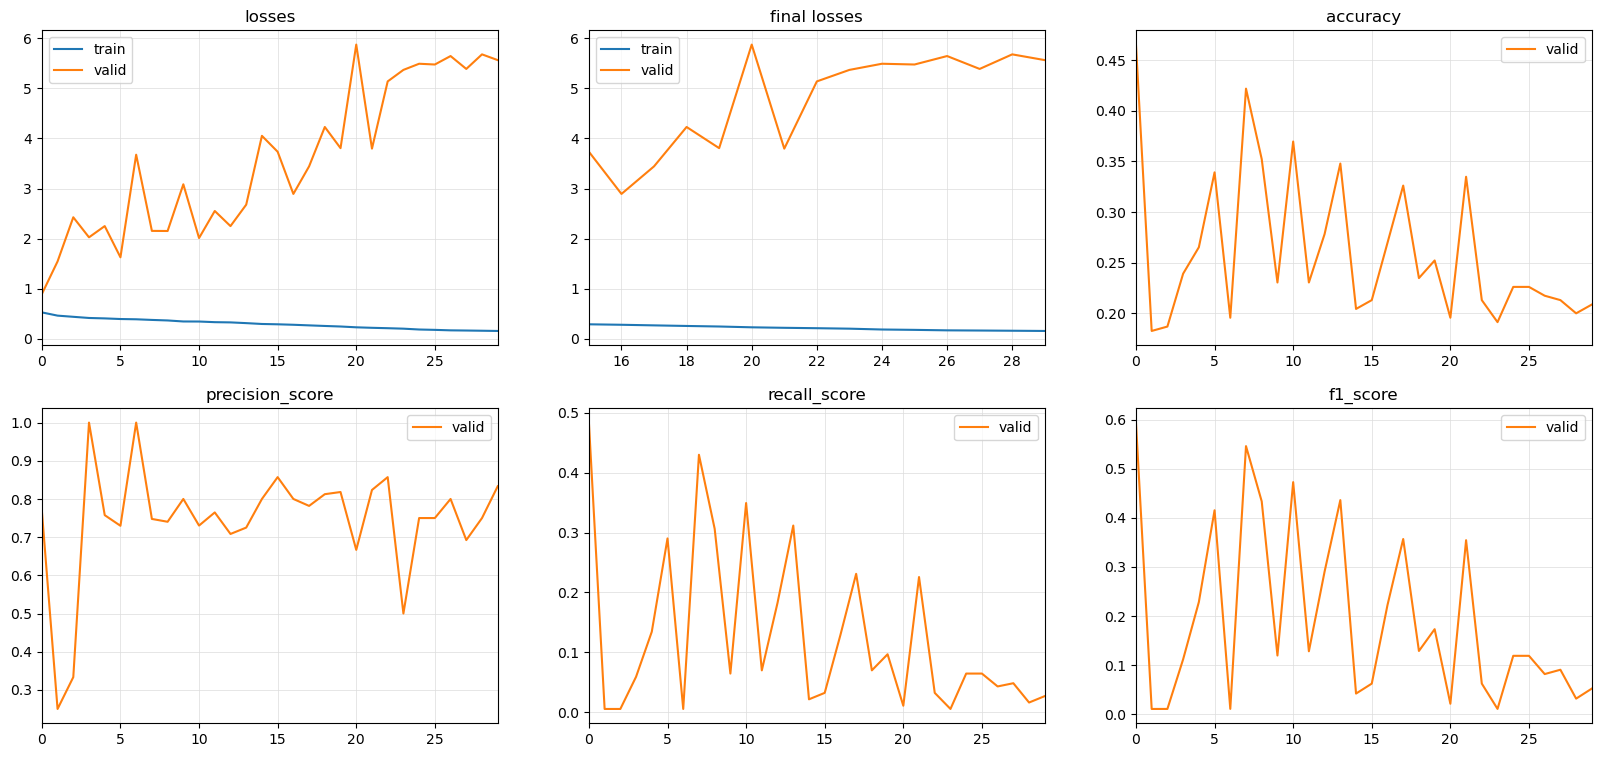

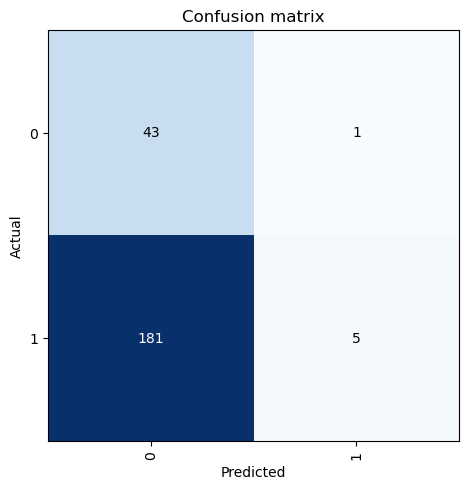

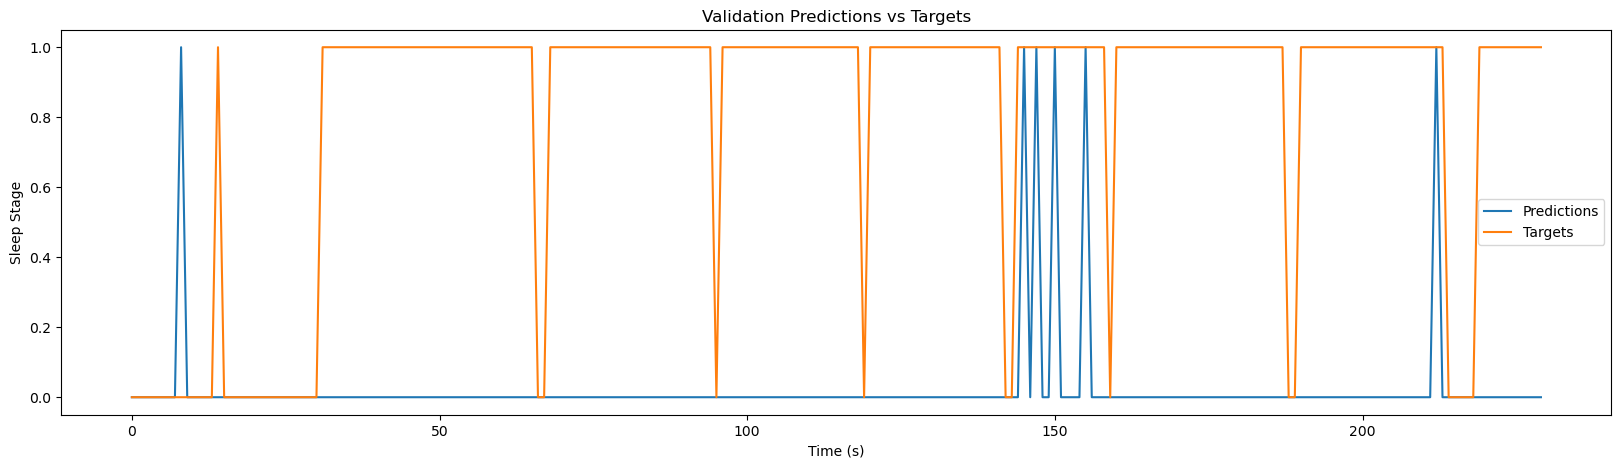

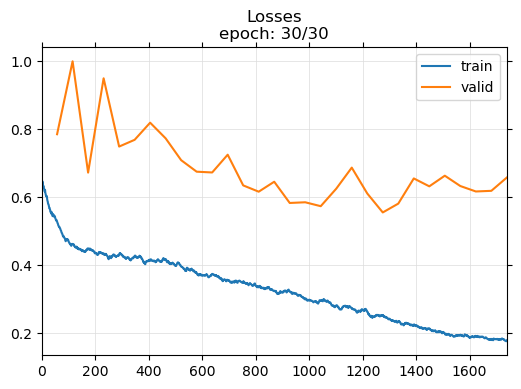

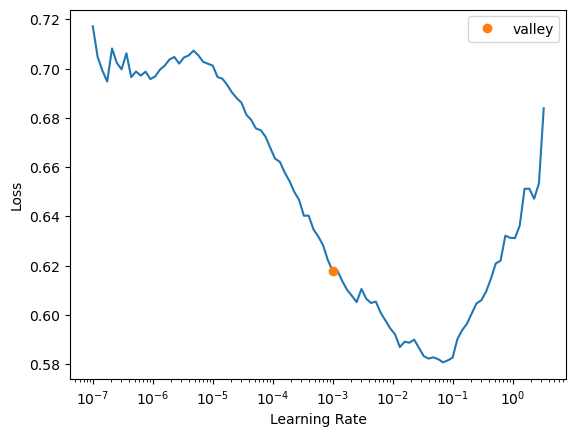

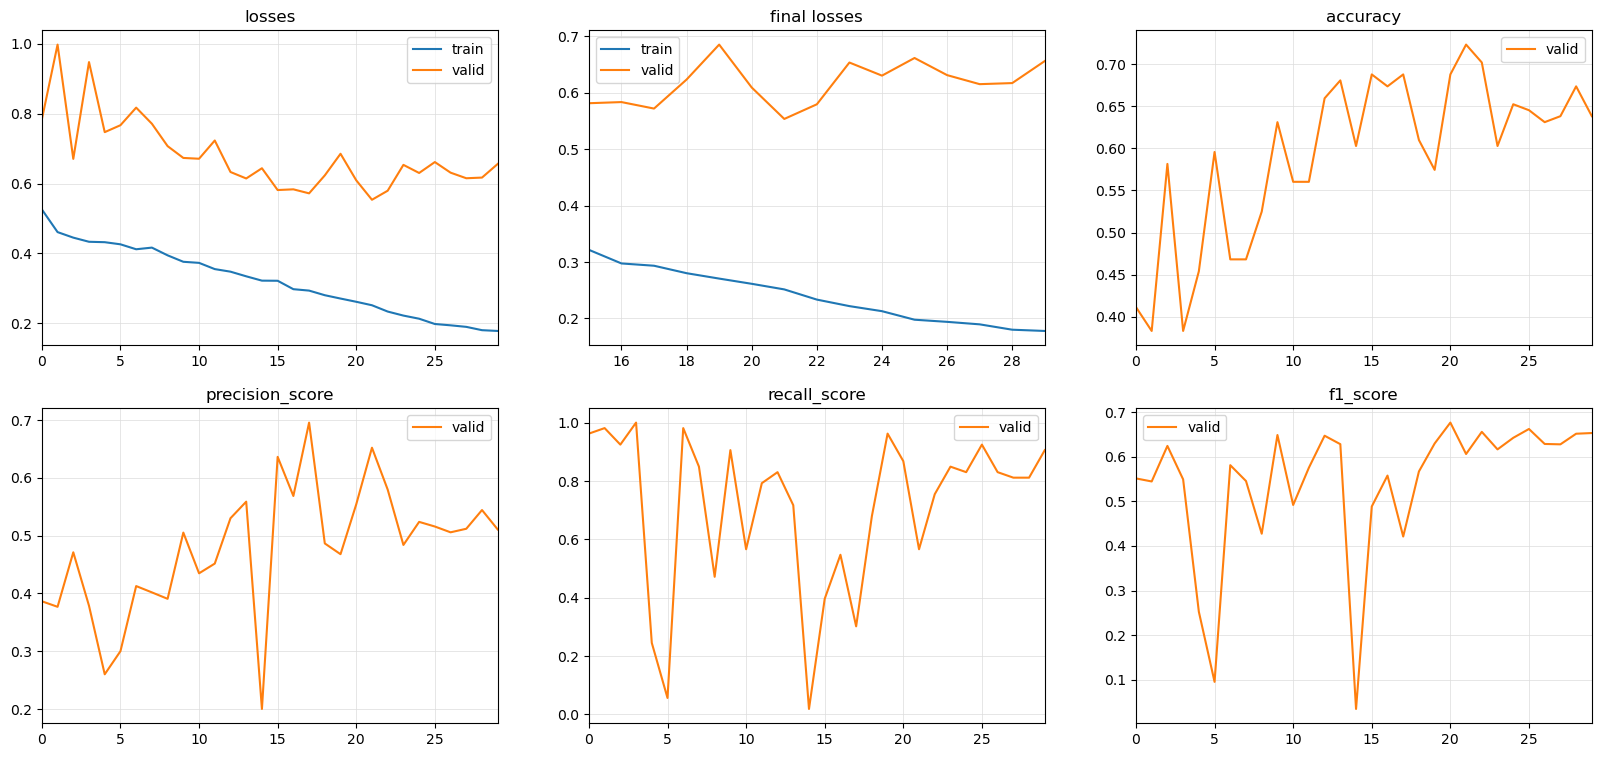

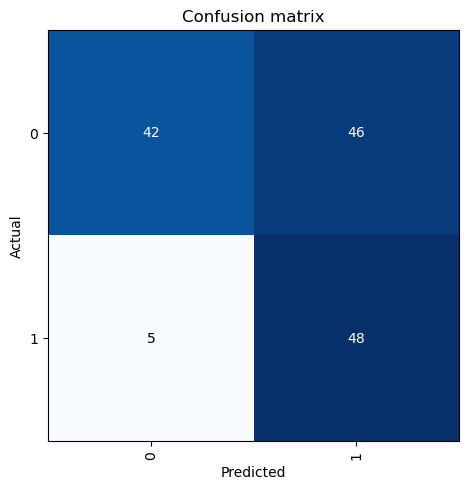

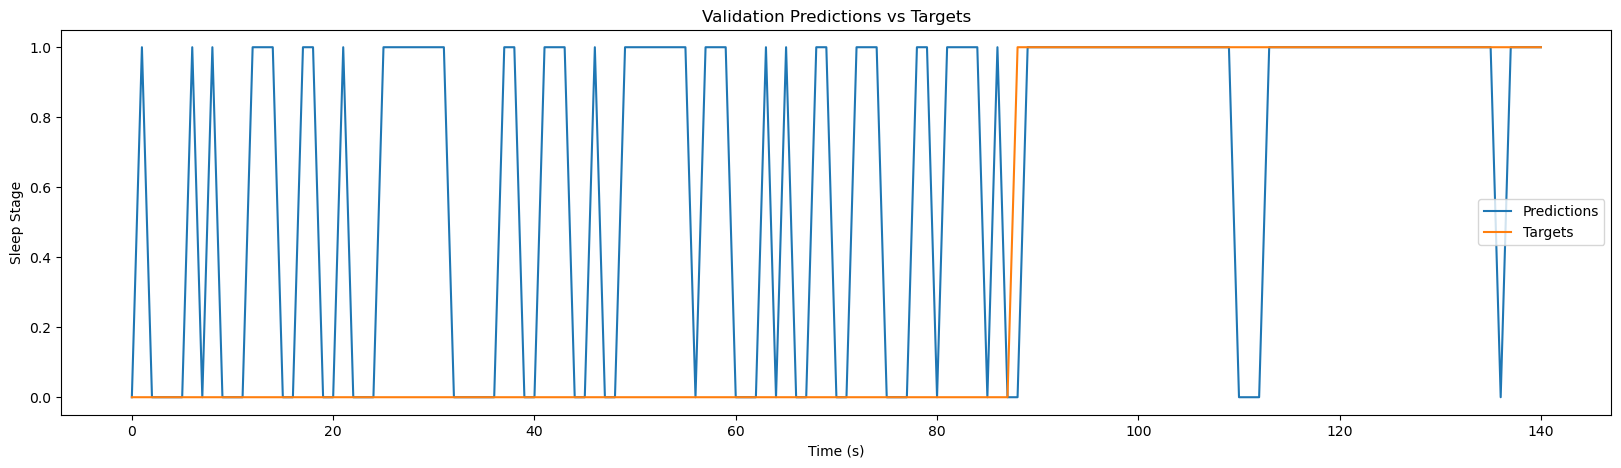

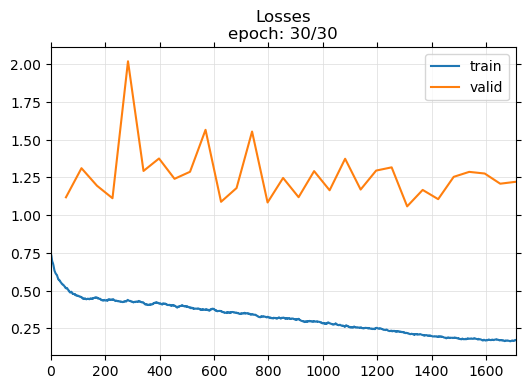

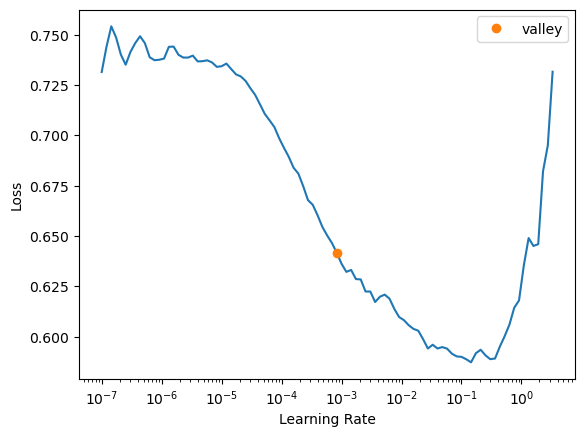

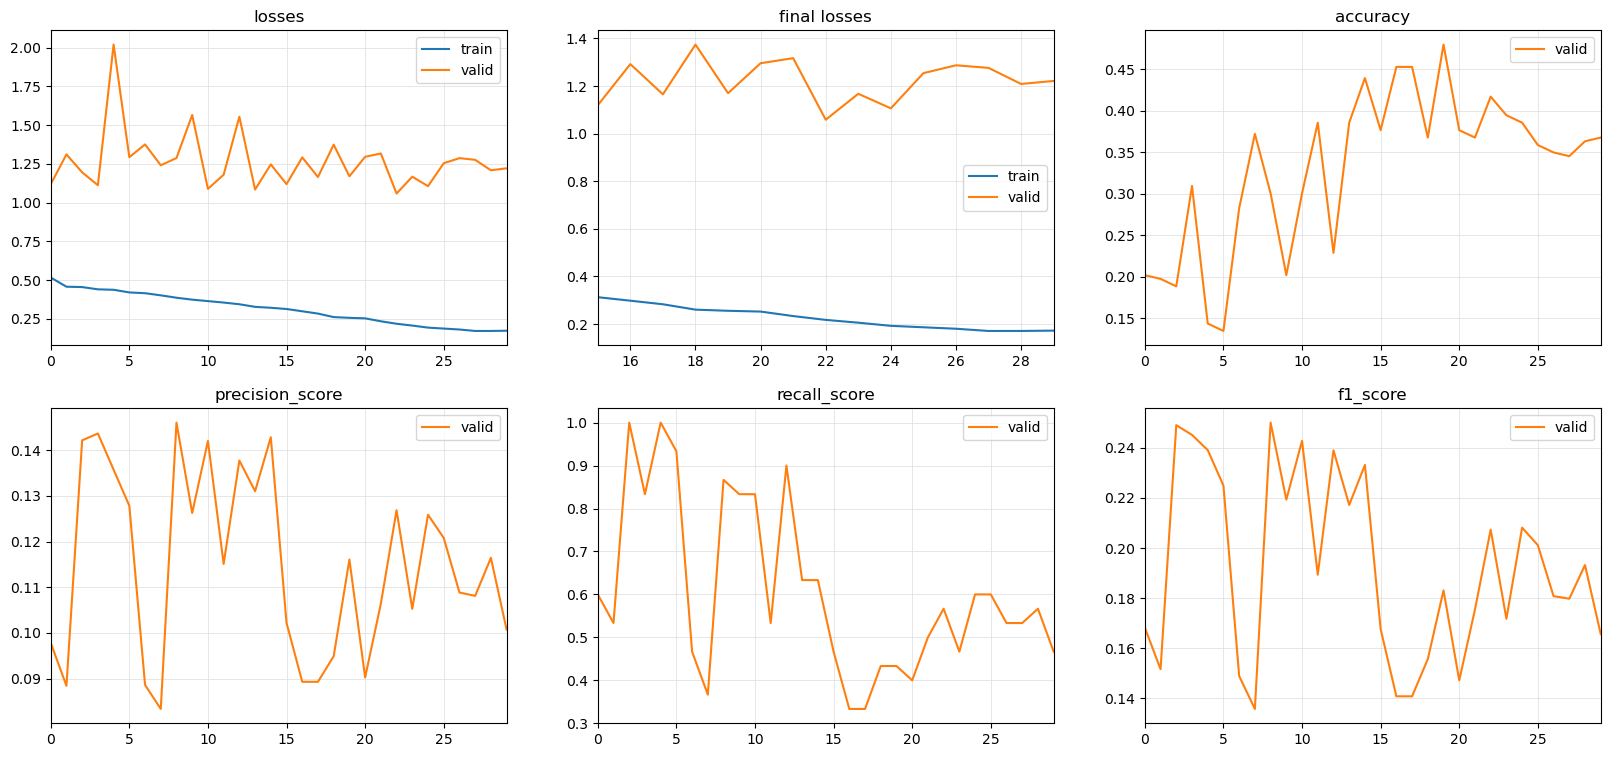

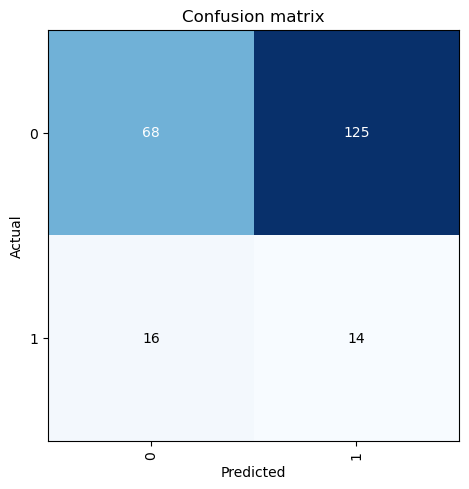

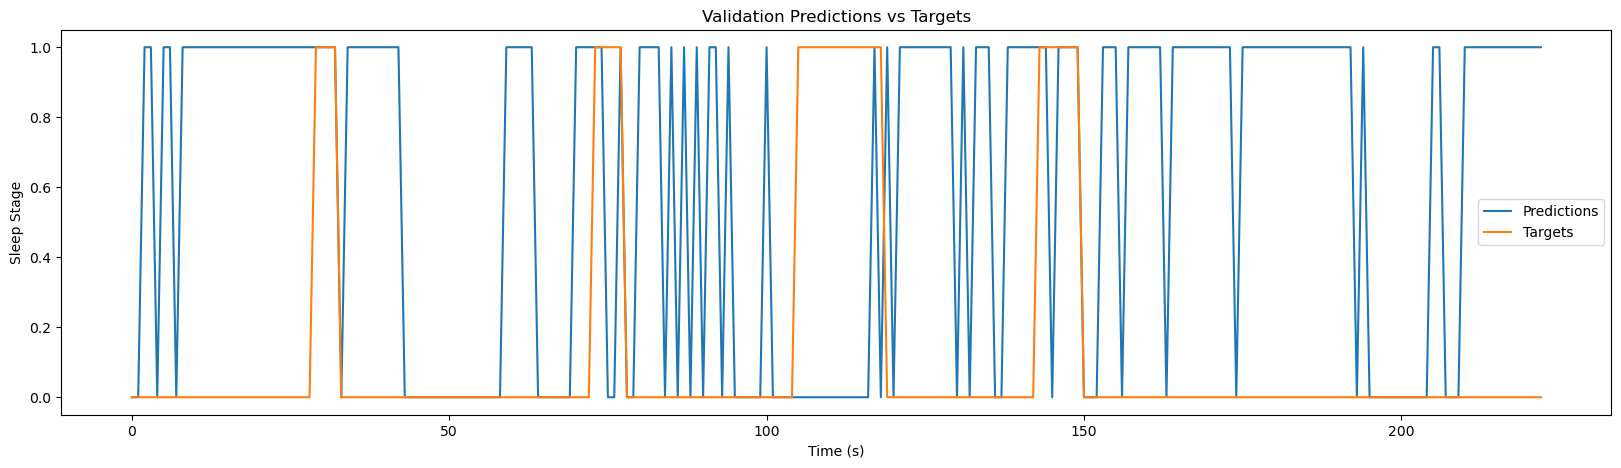

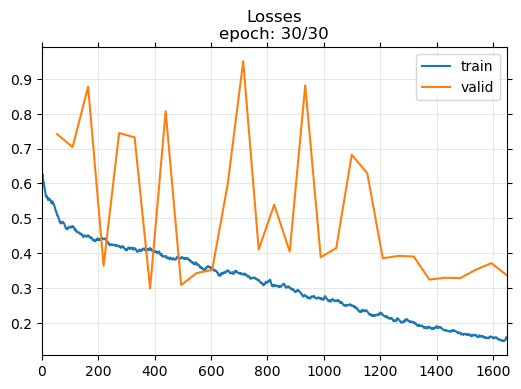

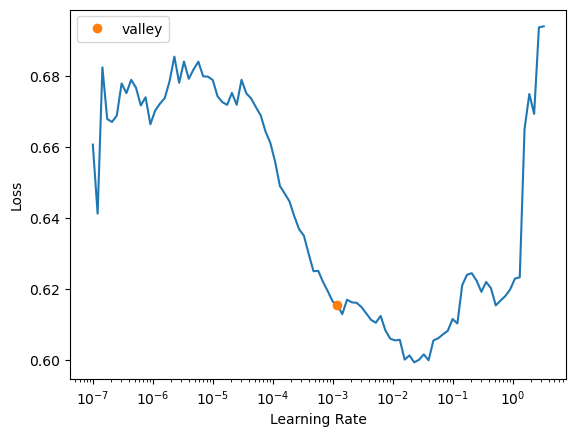

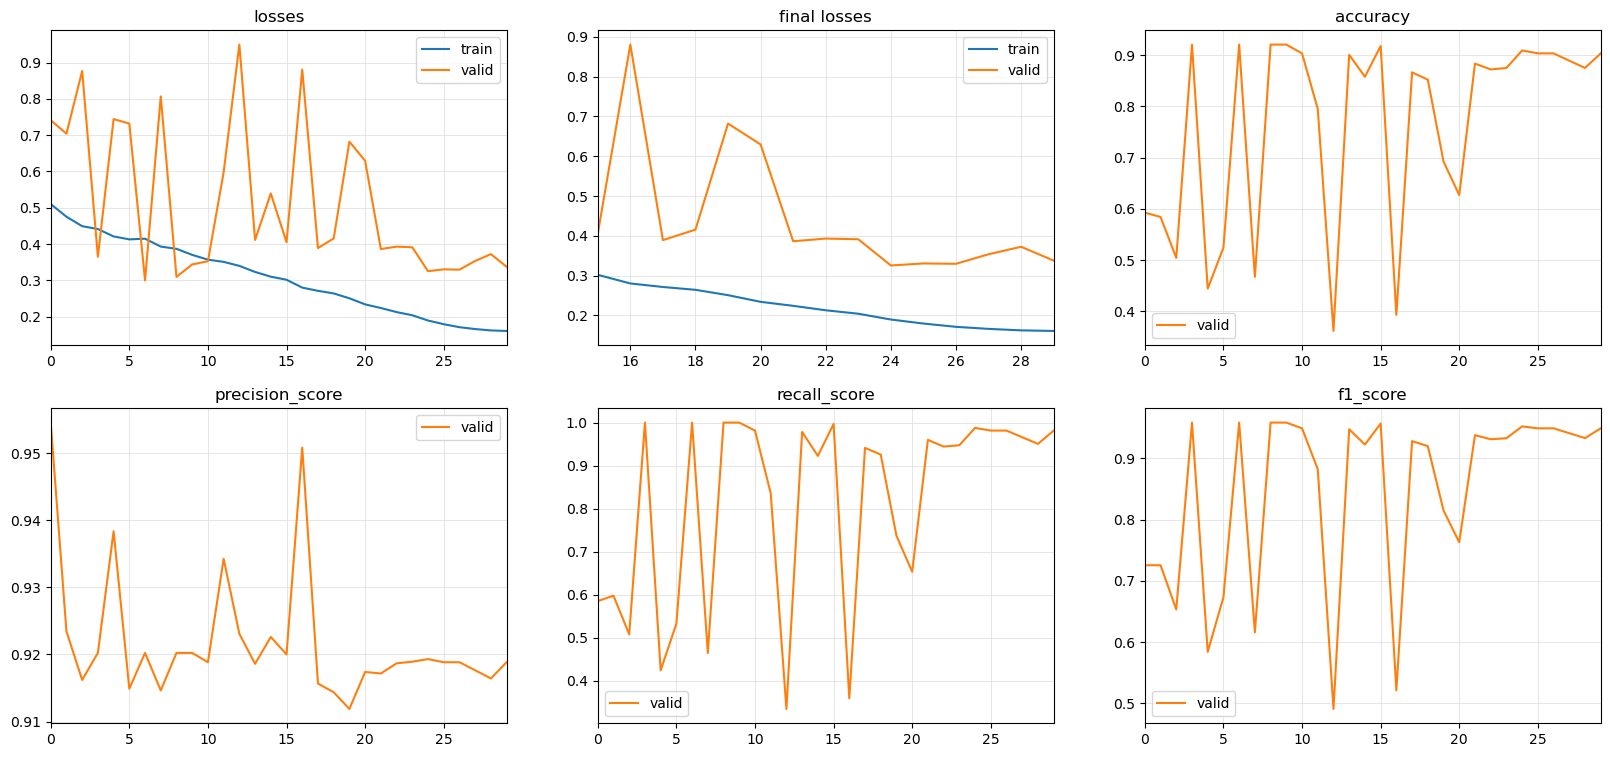

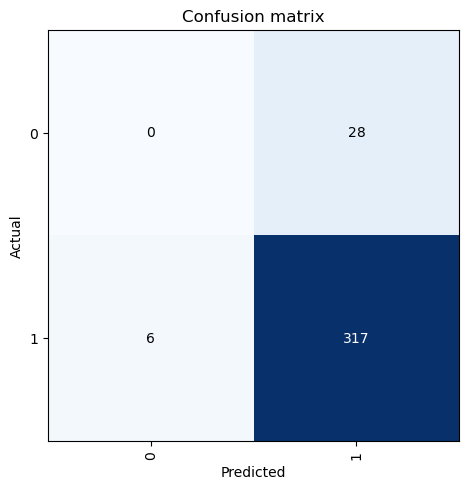

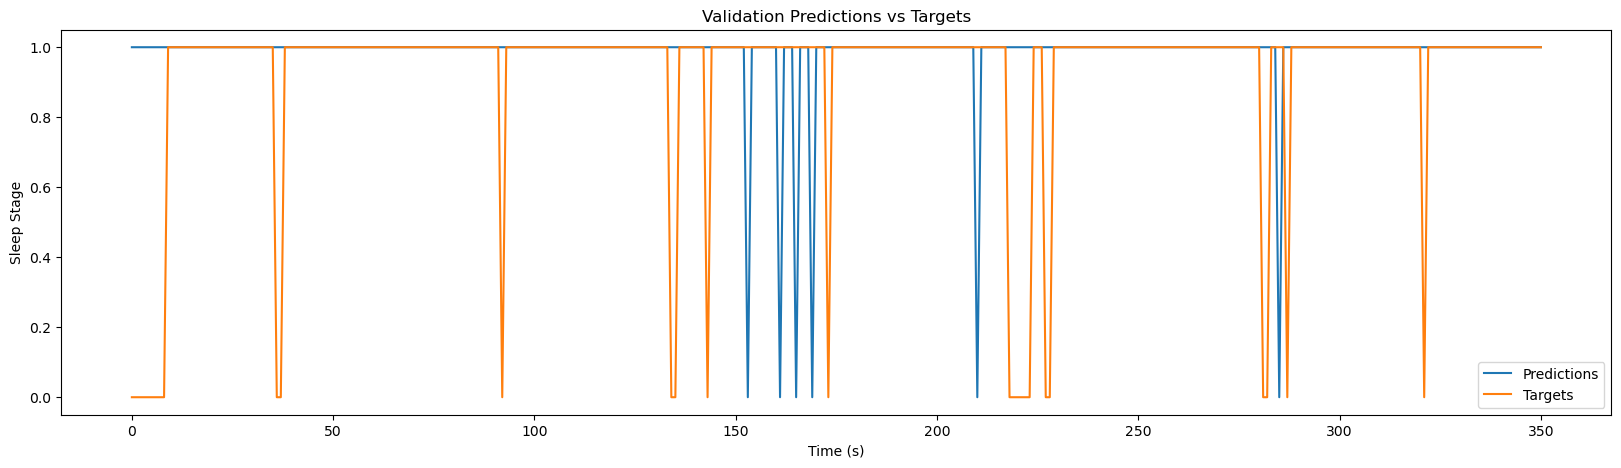

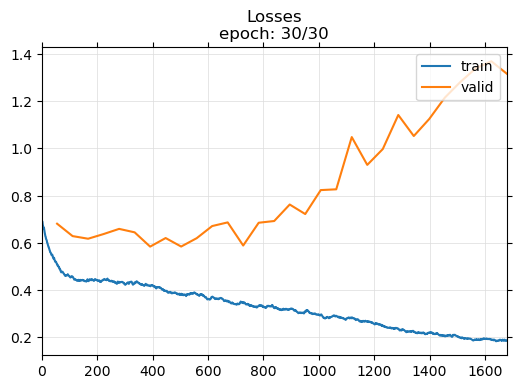

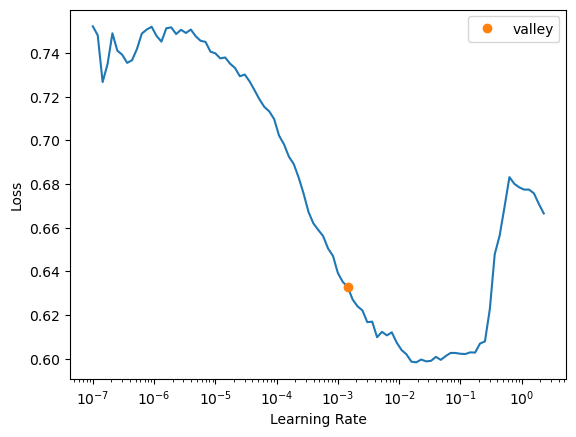

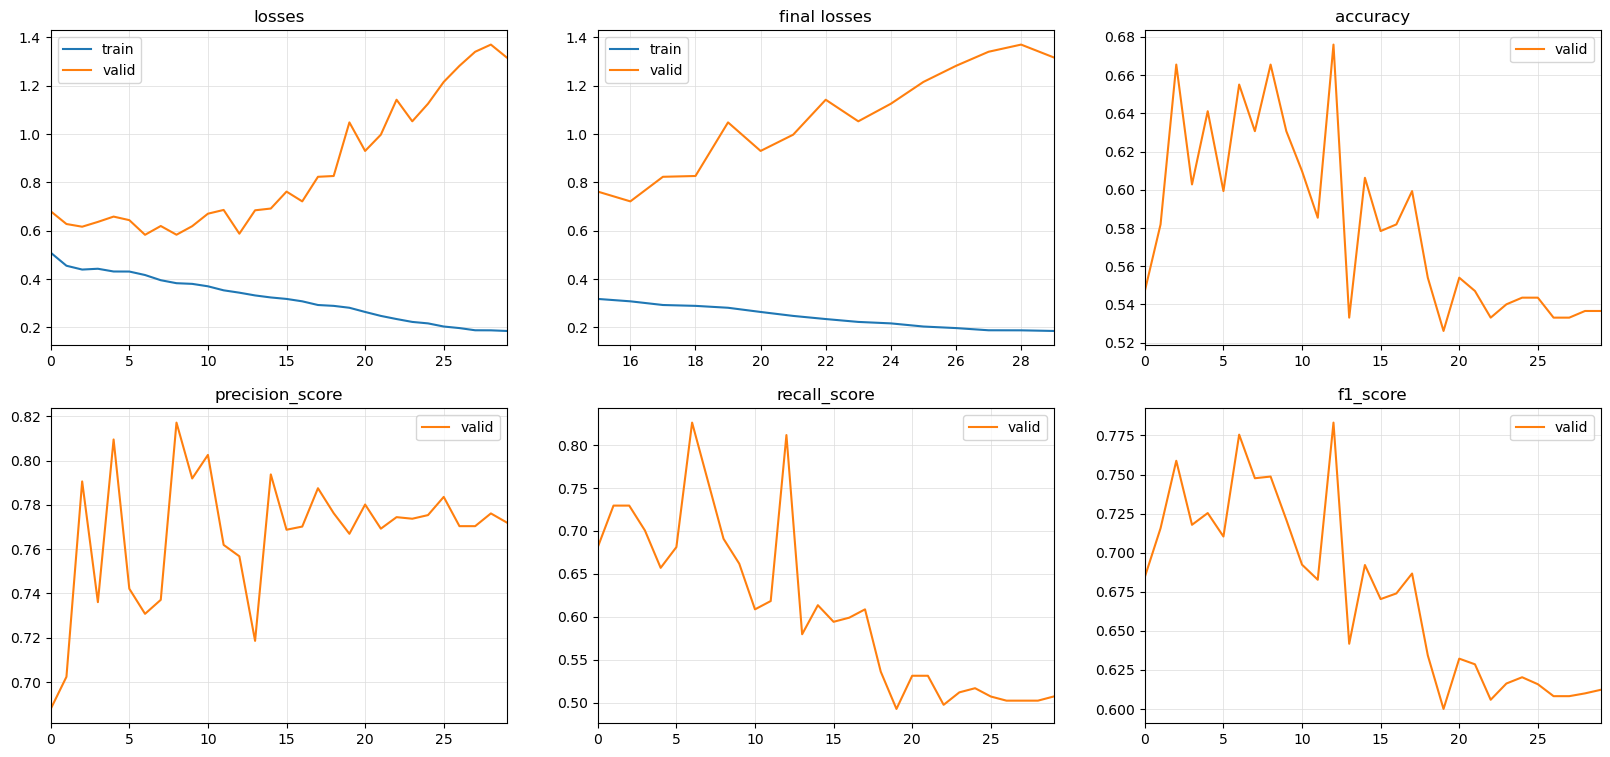

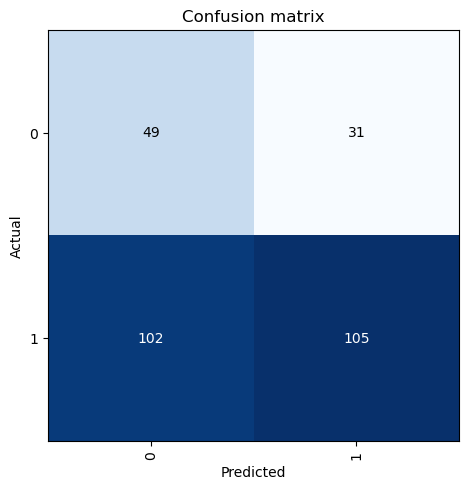

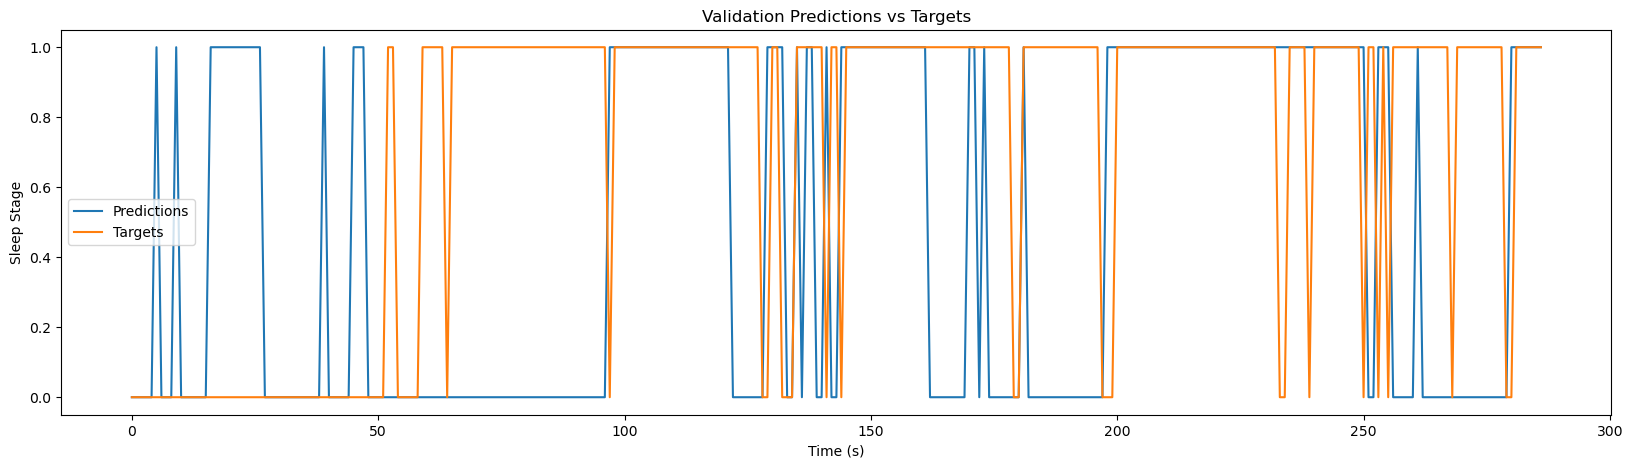

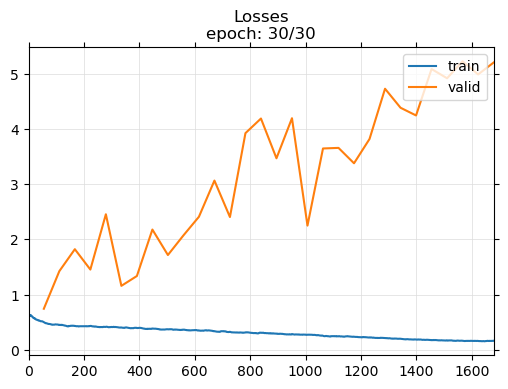

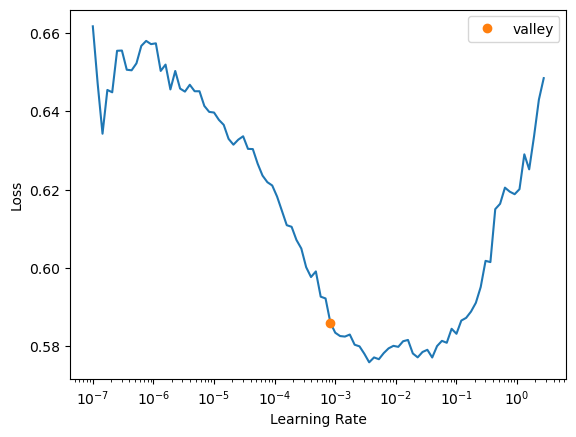

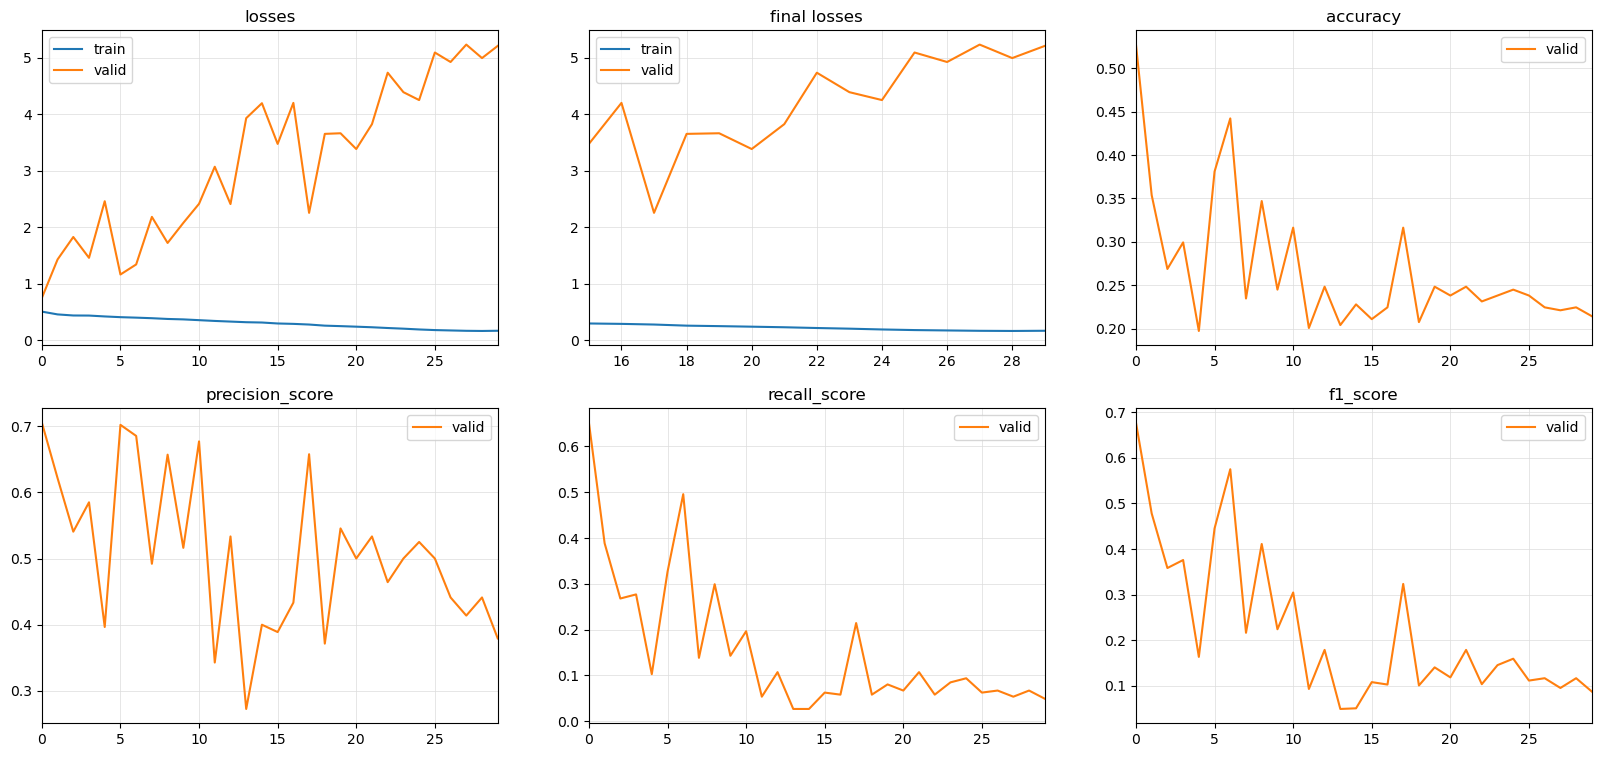

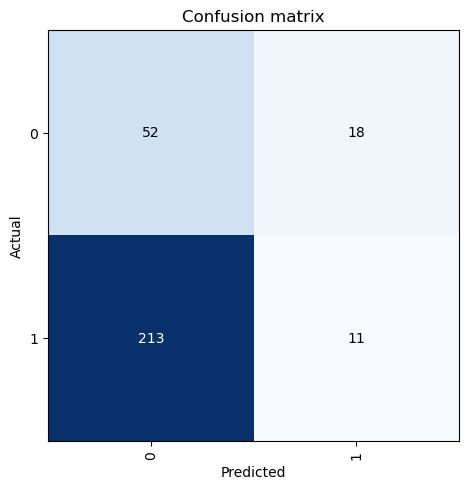

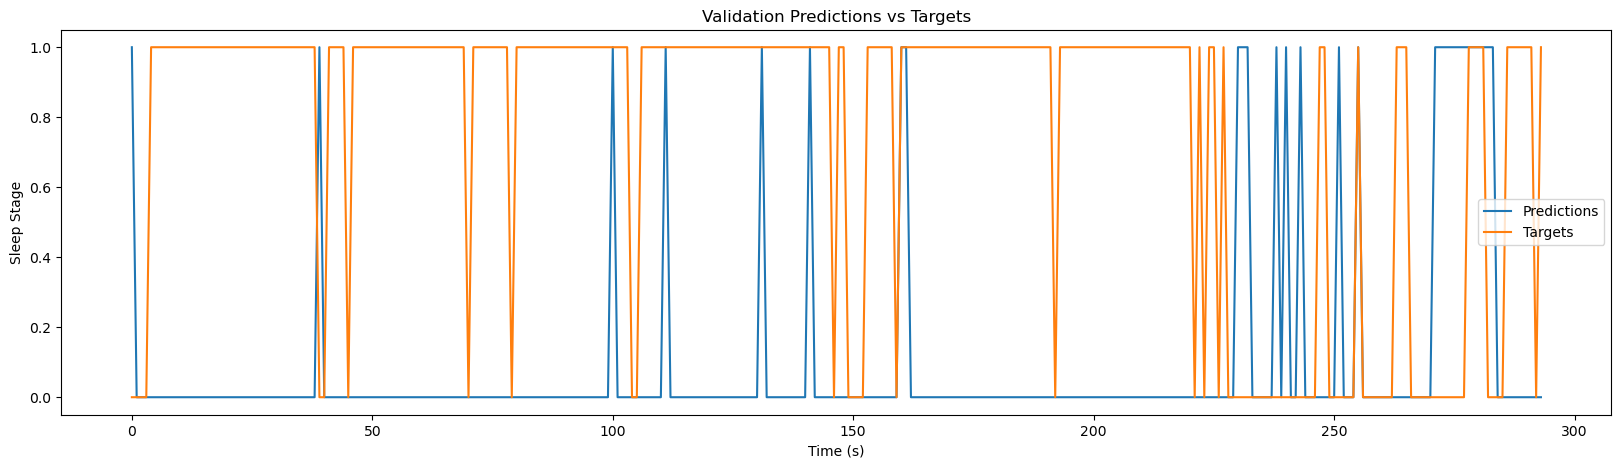

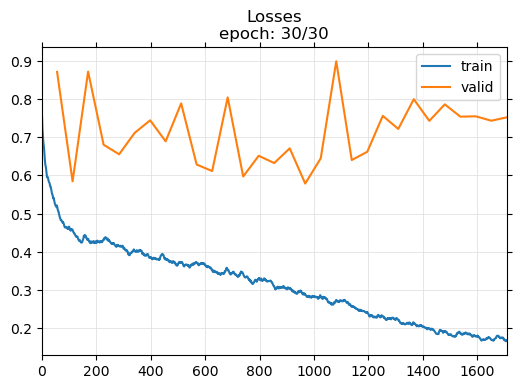

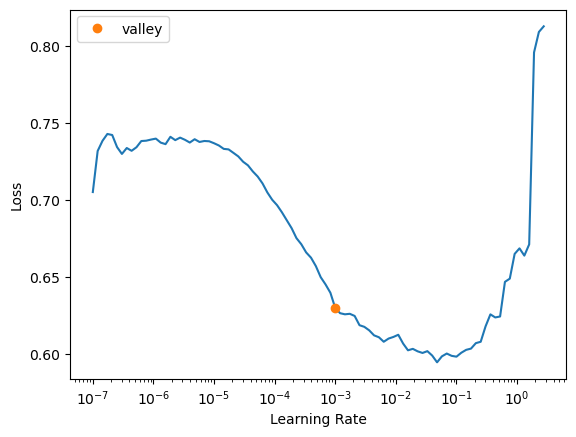

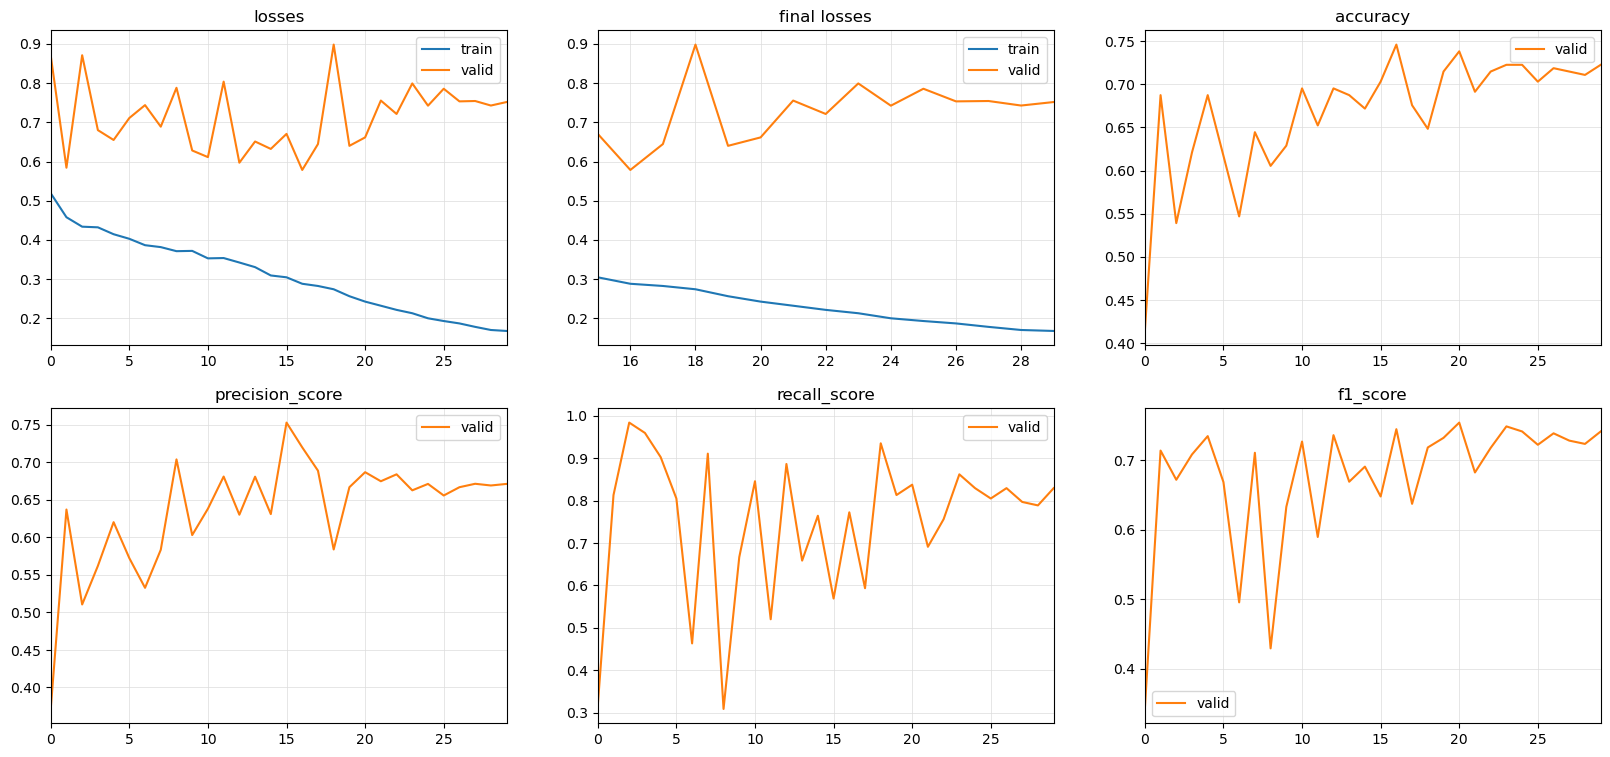

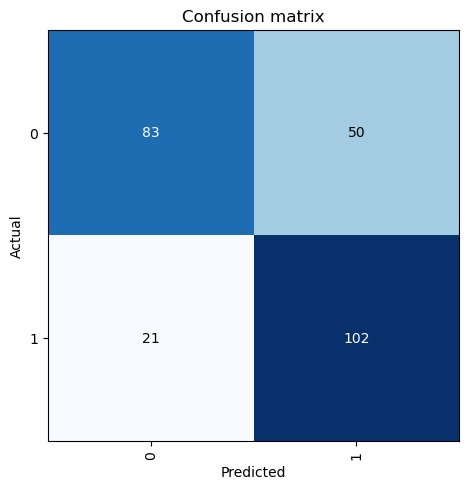

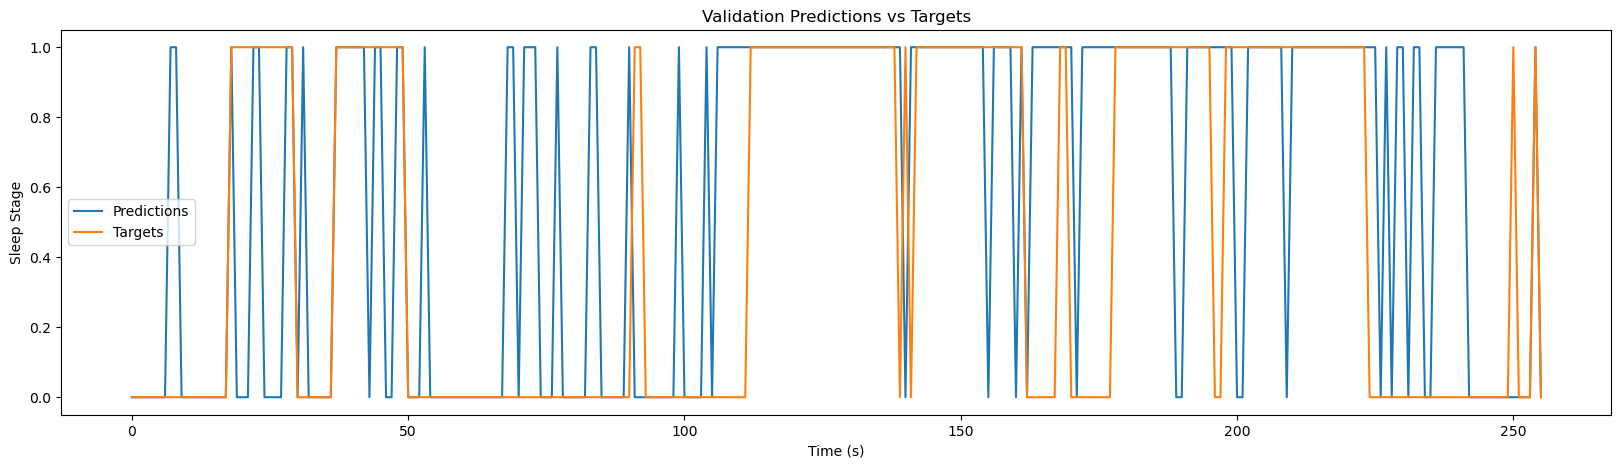

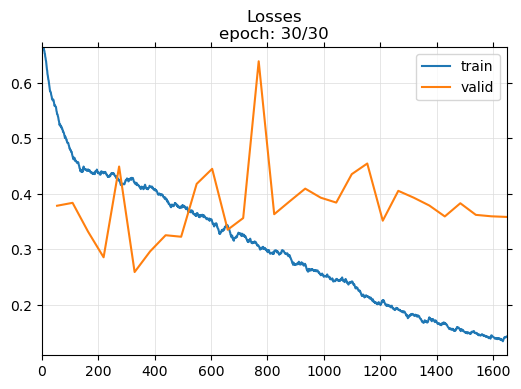

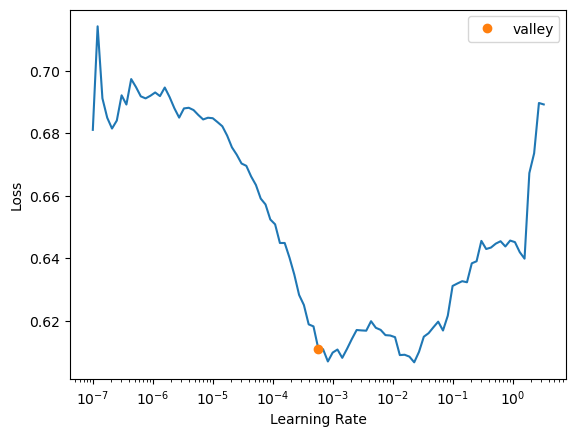

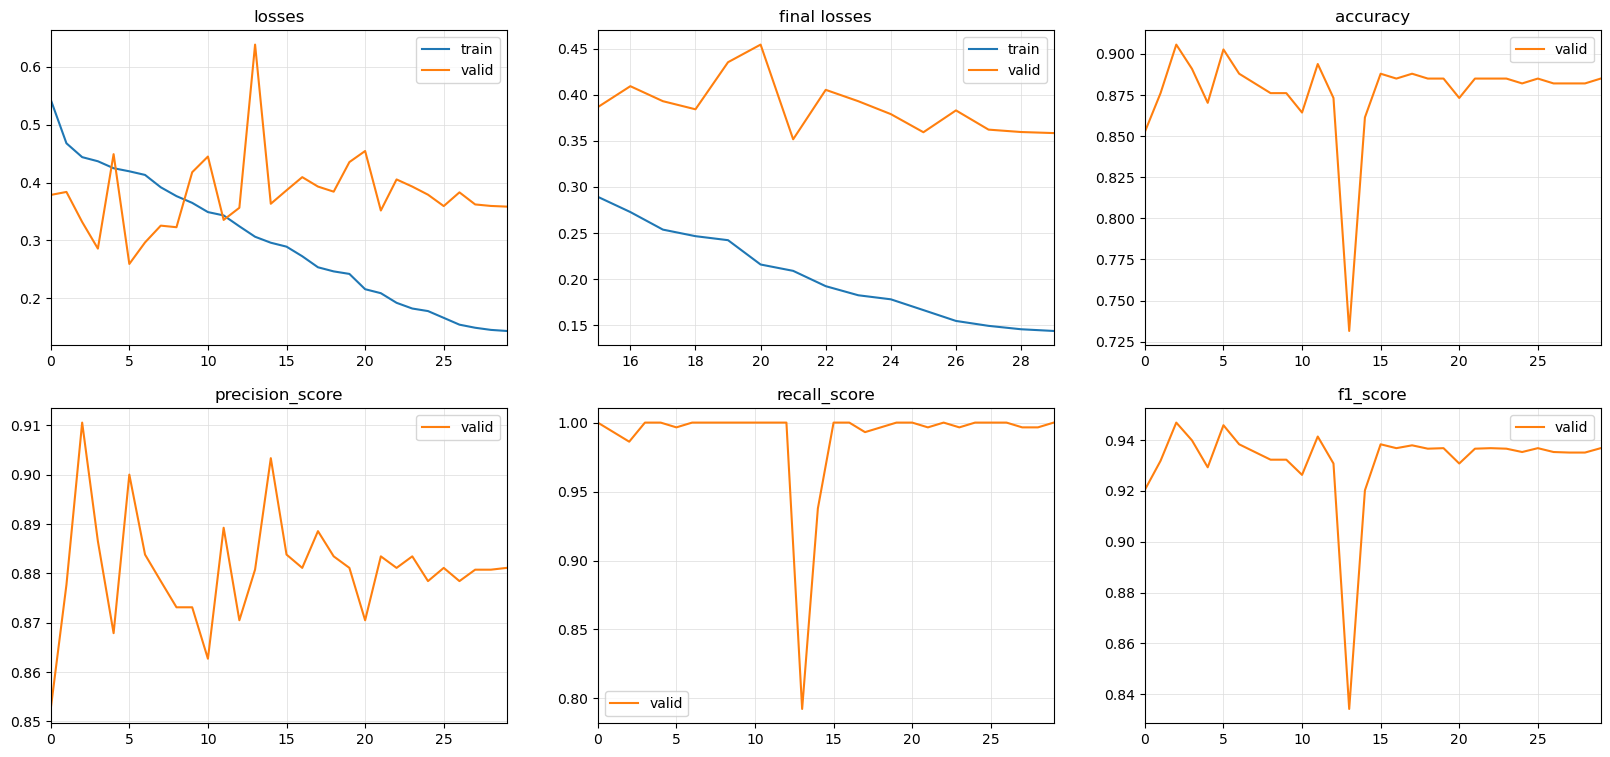

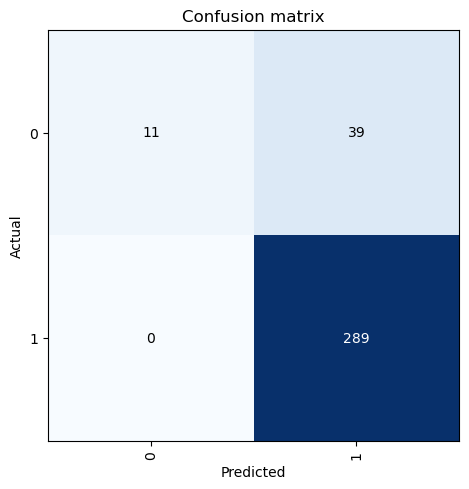

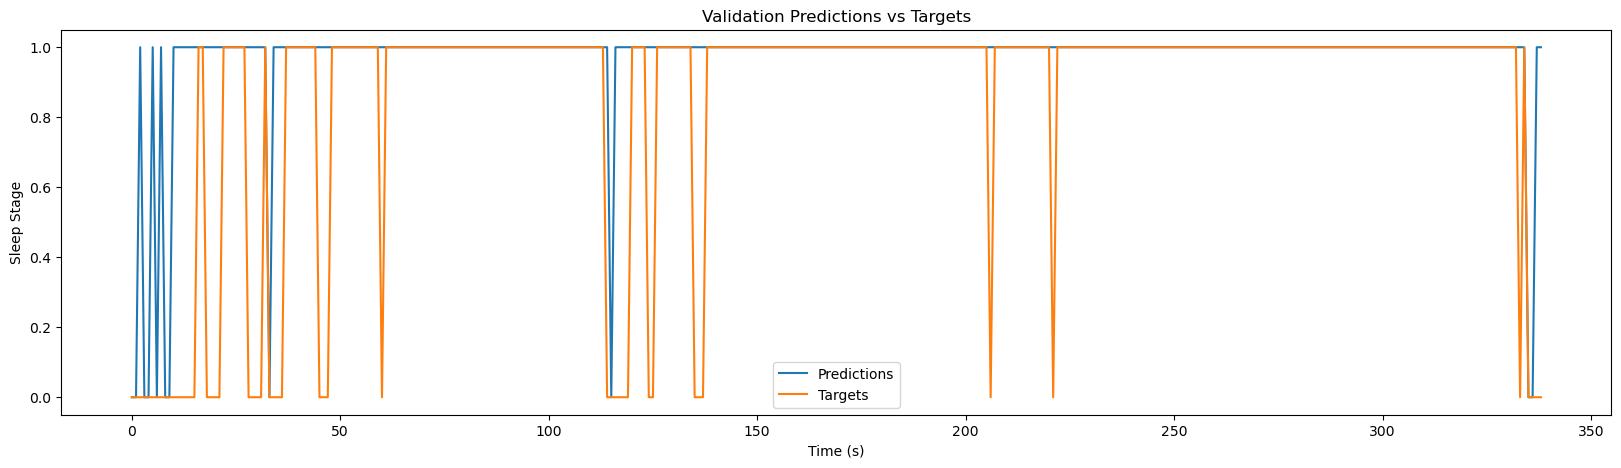

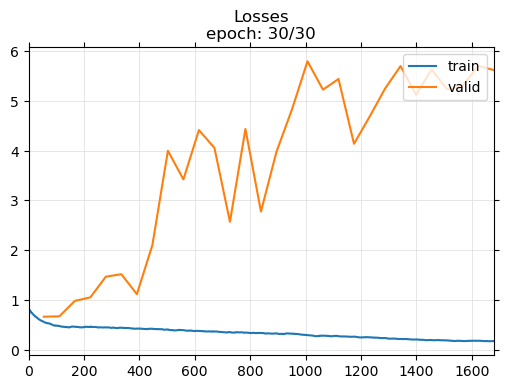

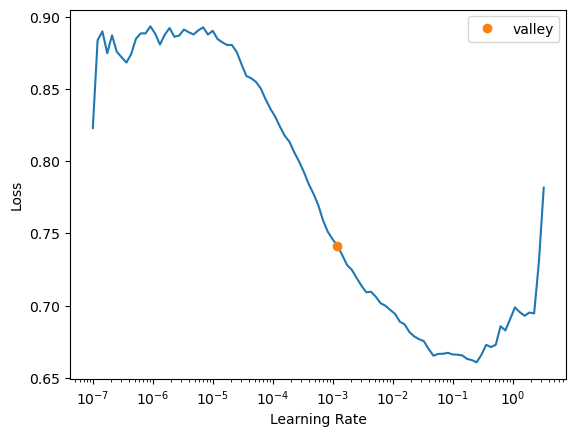

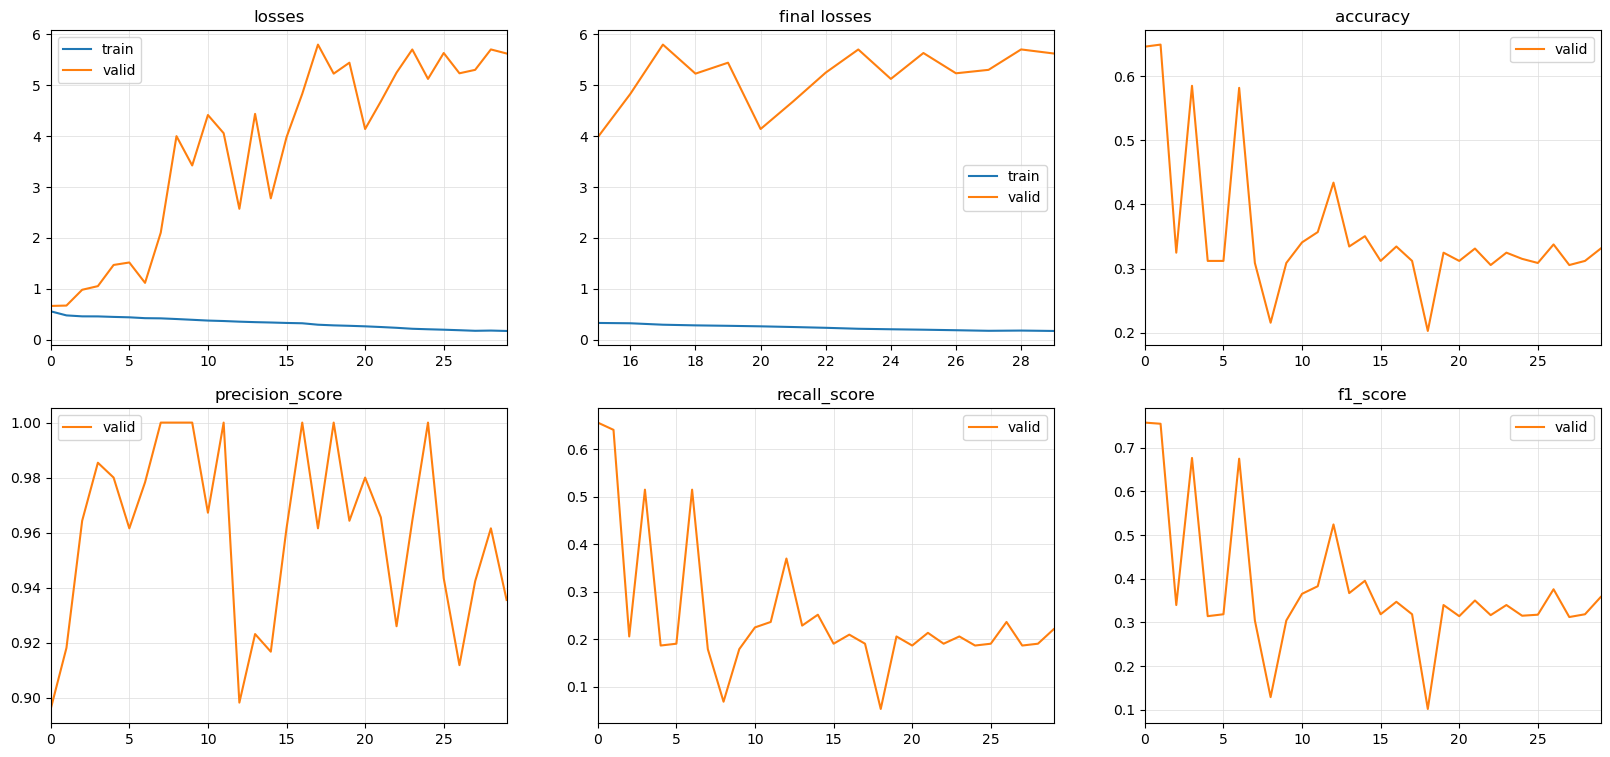

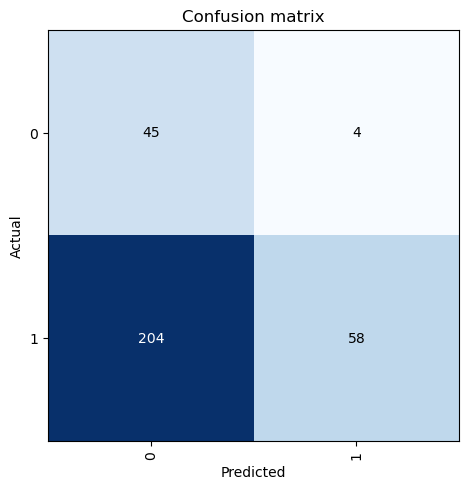

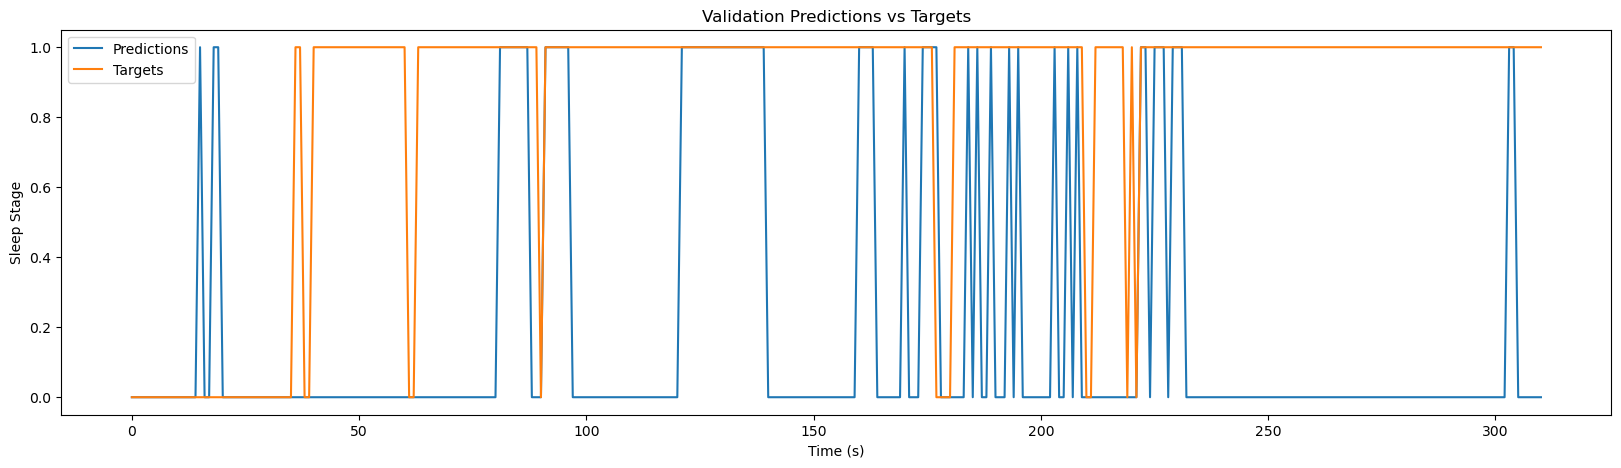

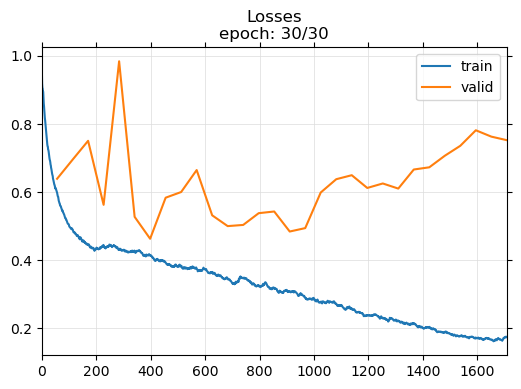

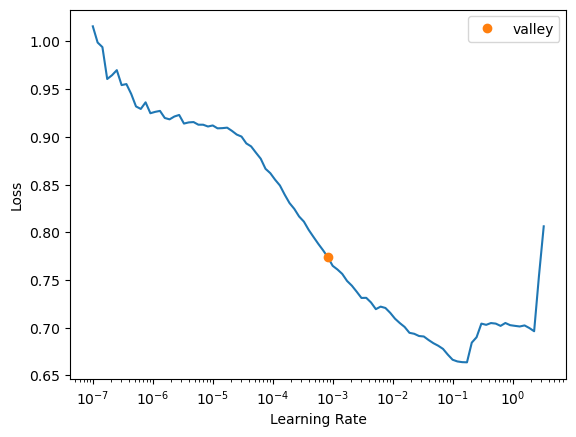

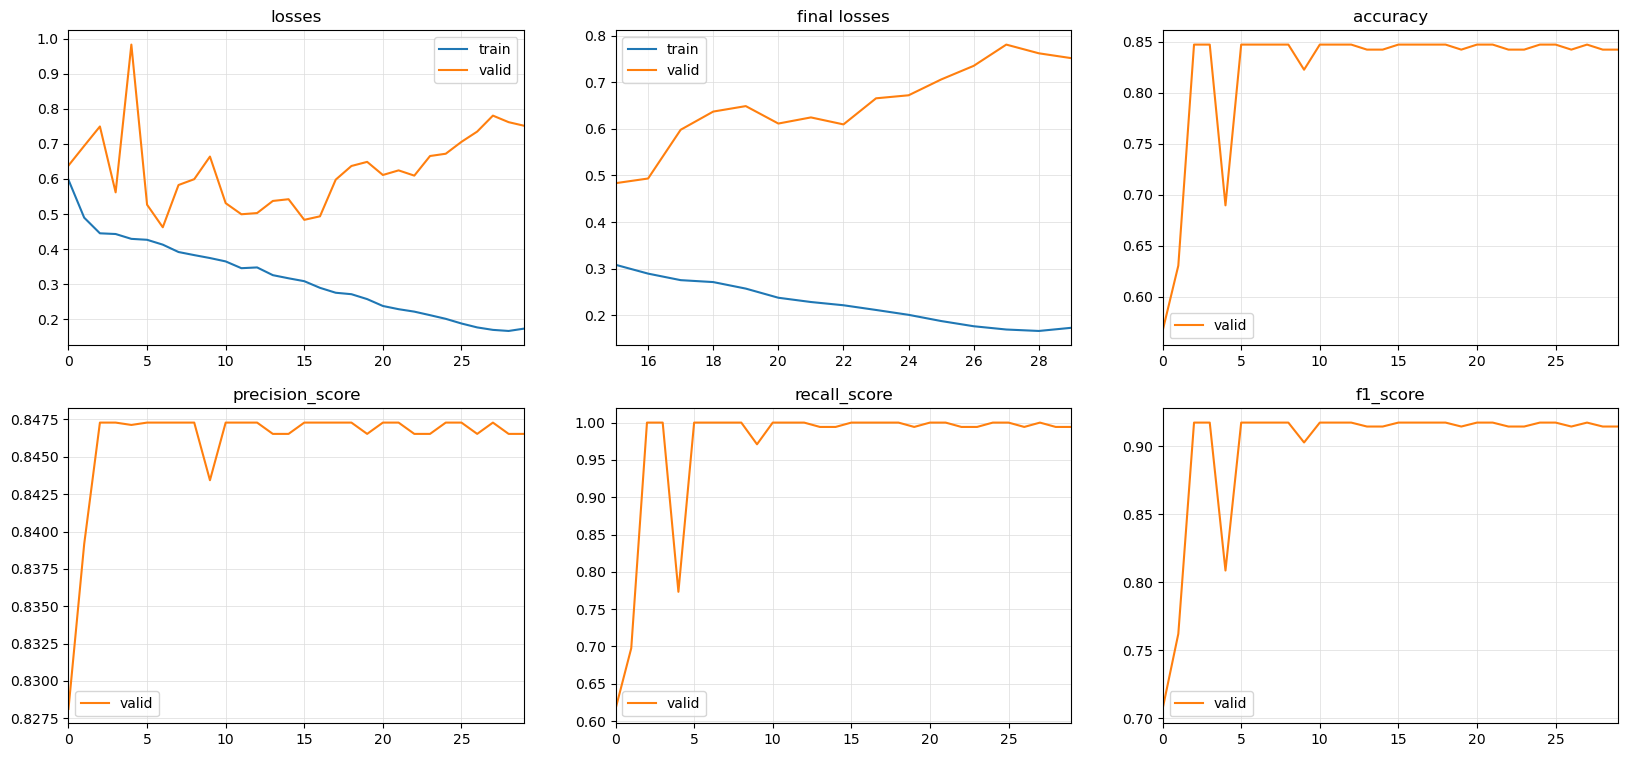

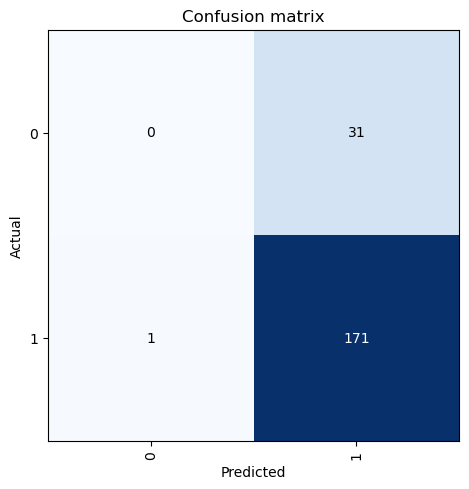

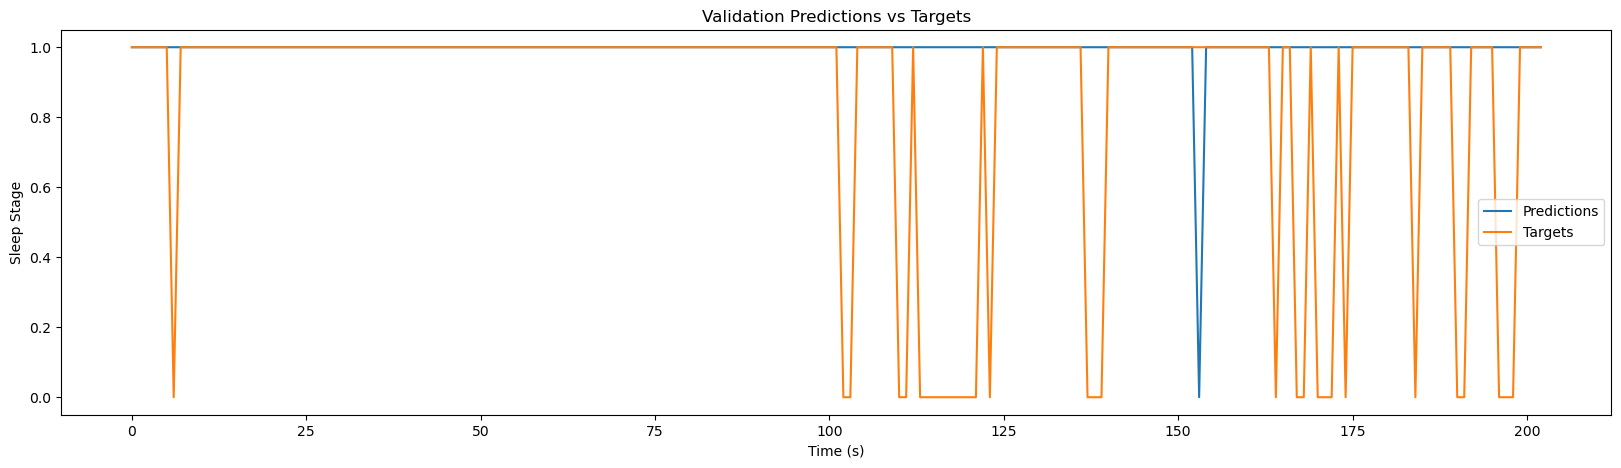

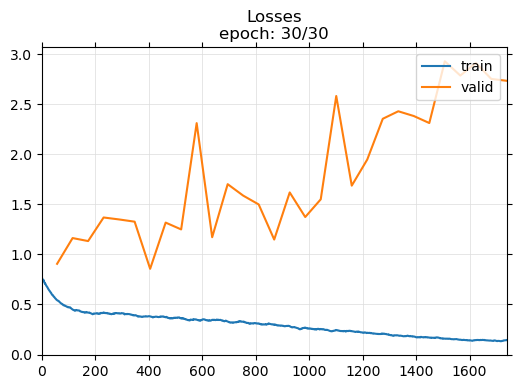

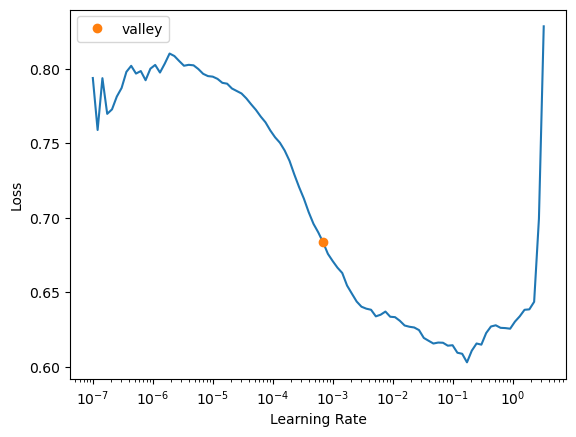

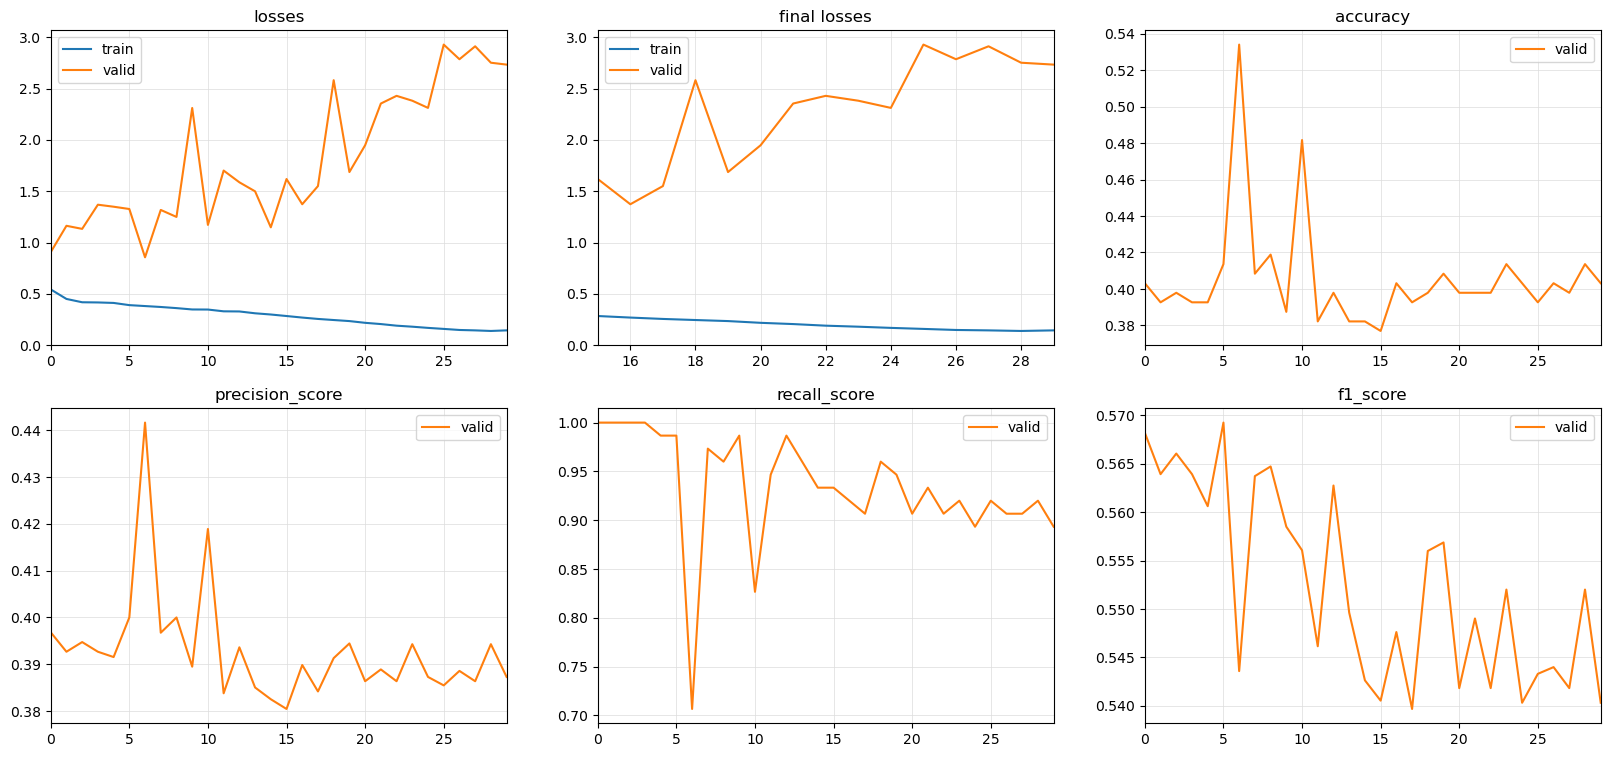

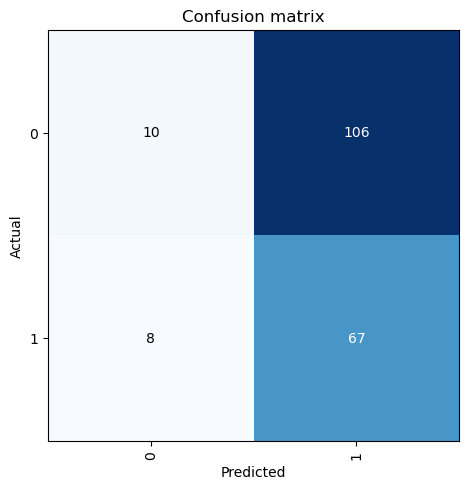

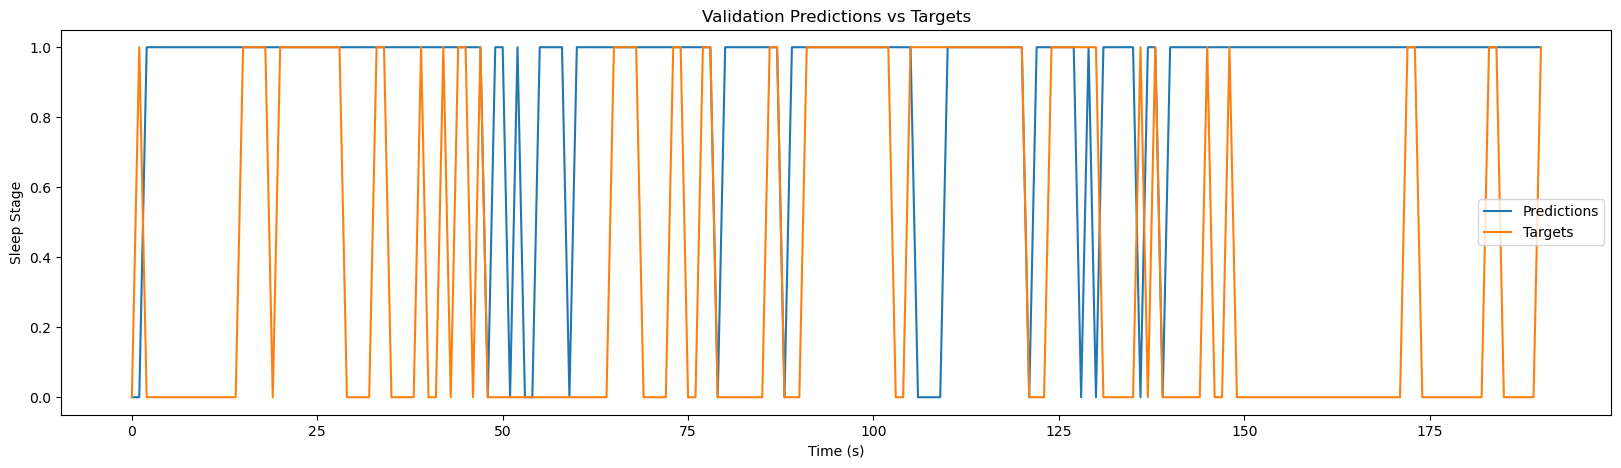

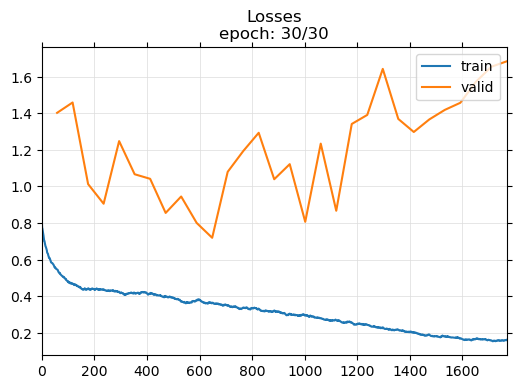

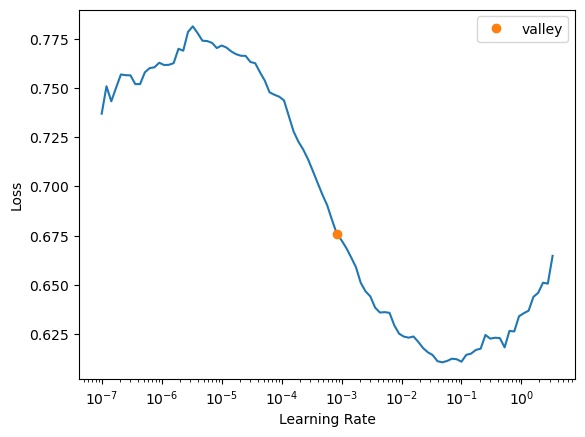

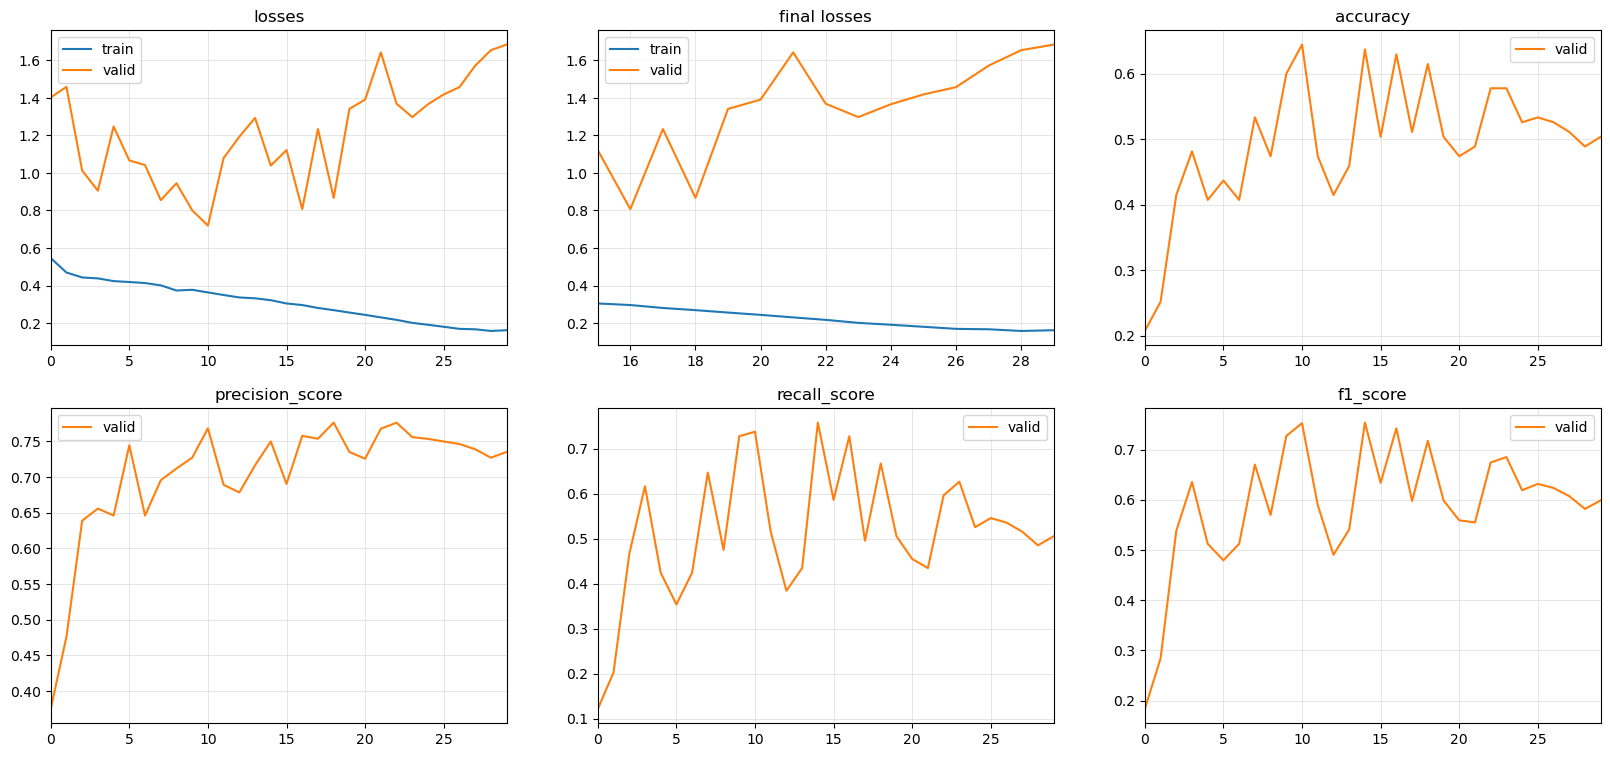

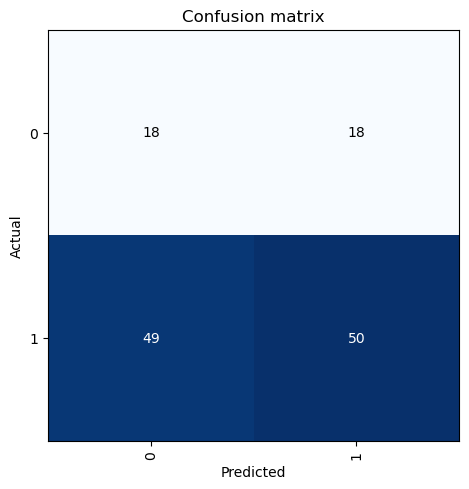

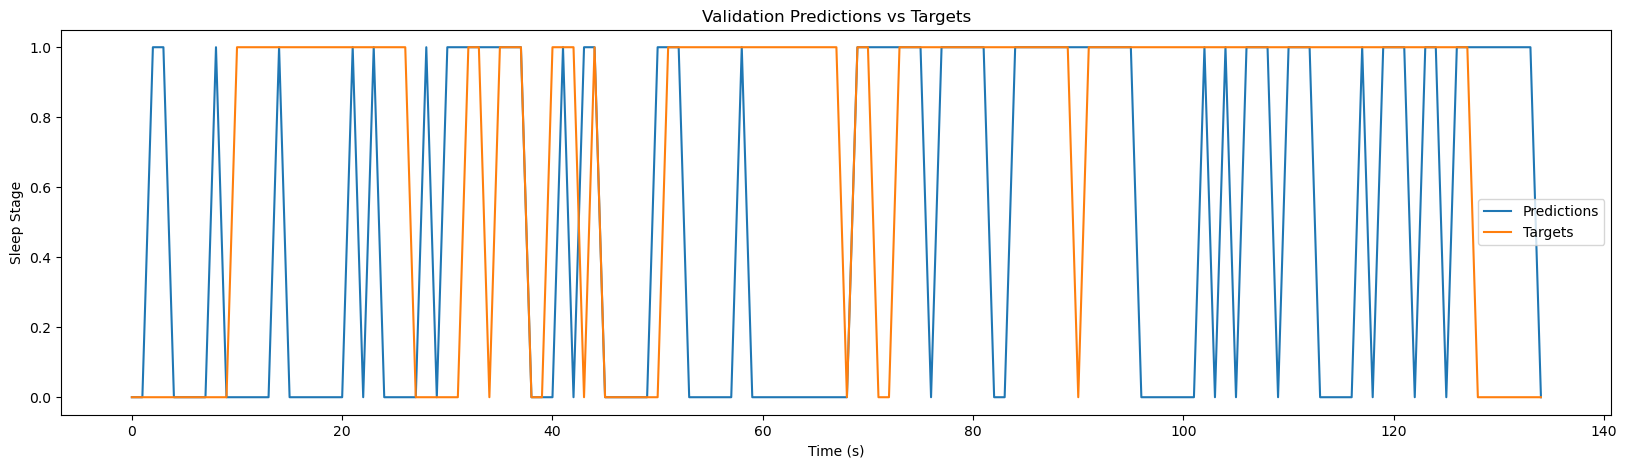

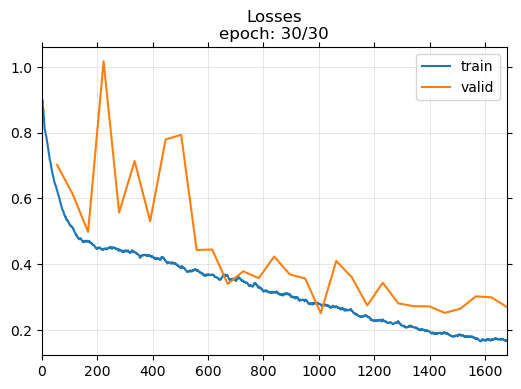

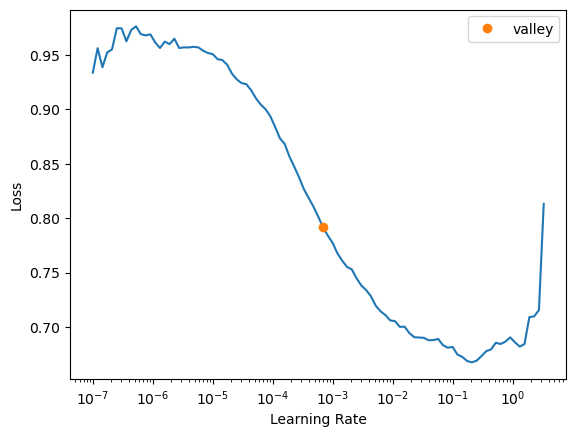

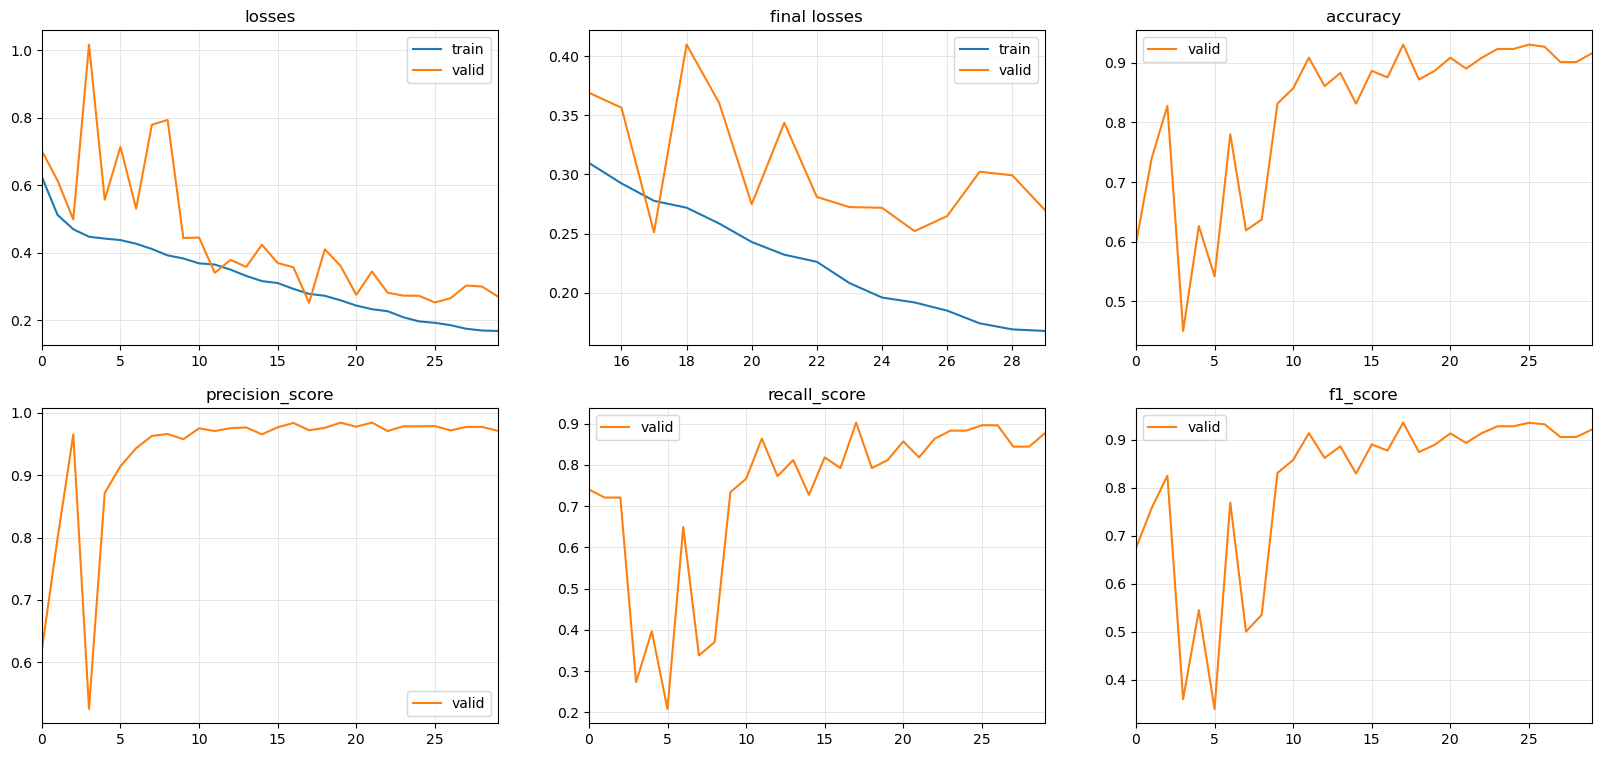

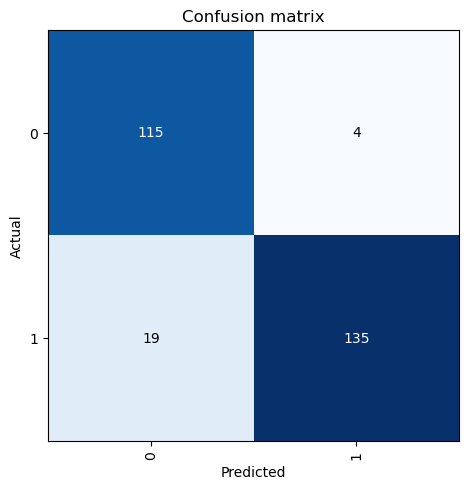

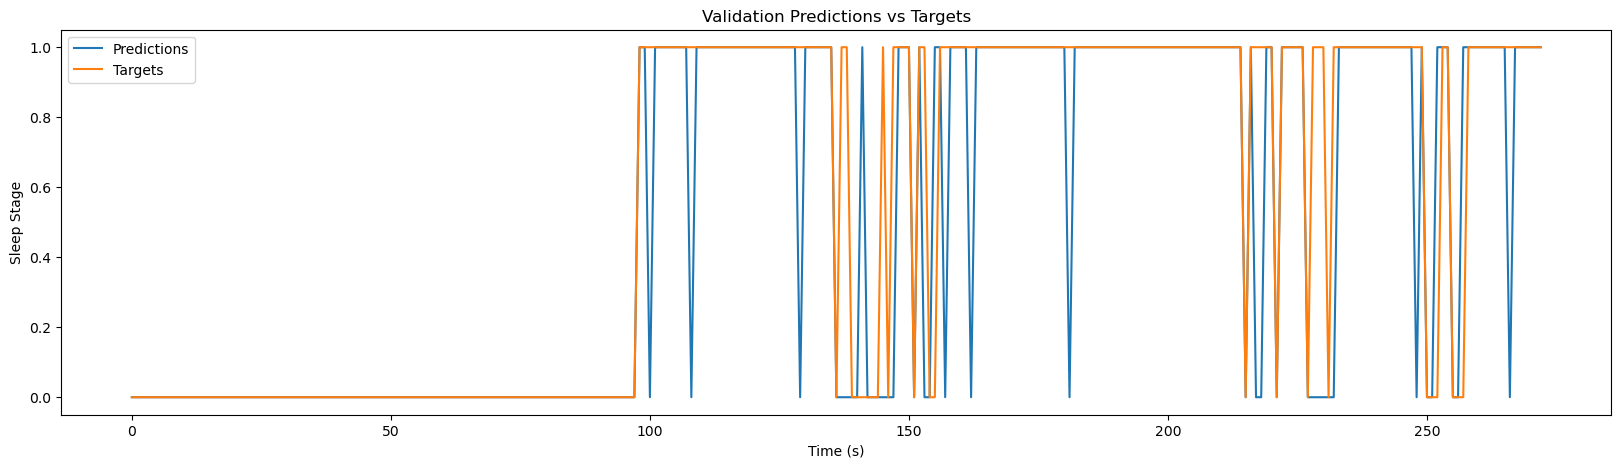

In [11]:
for i in range(len(data)):
    
    X, y, splits = train_valid_splits[i]

    train_and_evaluate_it(X, y, splits, [64, 128], 0.003, 30)


##### Save model

In [ ]:
# learn.save('all_features')

In [ ]:
# learn.save_all(path='export_all',
#                dls_fname='dls',
#                model_fname='model',
#                learner_fname='learner')

## Inferece


In [ ]:
# learn = load_learner_all(path='export_rmmsd',
#                          dls_fname='dls',
#                          model_fname='model',
#                          learner_fname='learner')

dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

In [ ]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl,
                                                           with_decoded=True)
valid_probas, valid_targets, valid_preds

In [ ]:
(valid_targets == valid_preds).float().mean()

In [ ]:
learn.show_results()


In [ ]:
learn.show_probas()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


In [ ]:
interp.most_confused(min_val=3)

In [ ]:
print(f'accuracy: {skm.accuracy_score(valid_targets, valid_preds):10.6f}')

# inference on unseen data

In [ ]:
# Read the data
test_data = pd.read_csv('final_test_processed.csv', index_col=0)

test_data = test_data[test_data.sleep_state != -1]

# Binary Classification
test_data["sleep_state"] = np.where(test_data["sleep_state"] == 0, 0, 1)

# fill NaN values
test_data = test_data.fillna(method='bfill', limit=1500).dropna()

# # set column time as datetime index
# df['time'] = pd.to_datetime(df['time'])
# df = df.set_index('time', drop=True)

test_data = test_data[['ledGreen', 'bpm', 'rmssd', 'pnn20', 'pnn50', 'hr_mad', 'sd1', 'sd2', 'accelerometerX', 'accelerometerY', 'accelerometerZ', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'sleep_state']]


# remove extreme values from the signal (outliers)
test_filtered_ppg = remove_extreme_values(test_data['ledGreen'], threshold=3.0)
test_filtered_bpm = remove_extreme_values(test_data['bpm'], threshold=3.0)
test_filtered_rmssd = remove_extreme_values(test_data['rmssd'], threshold=3.0)
test_filtered_pnn20 = remove_extreme_values(test_data['pnn20'], threshold=3.0)
test_filtered_pnn50 = remove_extreme_values(test_data['pnn50'], threshold=3.0)
test_filtered_hr_mad = remove_extreme_values(test_data['hr_mad'], threshold=3.0)
test_filtered_sd1 = remove_extreme_values(test_data['sd1'], threshold=3.0)
test_filtered_sd2 = remove_extreme_values(test_data['sd2'], threshold=3.0)
test_filtered_accelerometerX = remove_extreme_values(test_data['accelerometerX'],
                                                threshold=3.0)
test_filtered_accelerometerY = remove_extreme_values(test_data['accelerometerY'],
                                                threshold=3.0)
test_filtered_accelerometerZ = remove_extreme_values(test_data['accelerometerZ'],
                                                threshold=3.0)
test_filtered_gyroscopeX = remove_extreme_values(test_data['gyroscopeX'], threshold=3.0)
test_filtered_gyroscopeY = remove_extreme_values(test_data['gyroscopeY'], threshold=3.0)
test_filtered_gyroscopeZ = remove_extreme_values(test_data['gyroscopeZ'], threshold=3.0)

test_data['ledGreen'] = test_filtered_ppg
test_data['bpm'] = test_filtered_bpm
test_data['rmssd'] = test_filtered_rmssd
test_data['pnn20'] = test_filtered_pnn20
test_data['pnn50'] = test_filtered_pnn50
test_data['hr_mad'] = test_filtered_hr_mad
test_data['sd1'] = test_filtered_sd1
test_data['sd2'] = test_filtered_sd2
test_data['accelerometerX'] = test_filtered_accelerometerX
test_data['accelerometerY'] = test_filtered_accelerometerY
test_data['accelerometerZ'] = test_filtered_accelerometerZ
test_data['gyroscopeX'] = test_filtered_gyroscopeX
test_data['gyroscopeY'] = test_filtered_gyroscopeY
test_data['gyroscopeZ'] = test_filtered_gyroscopeZ

test_data = test_data.dropna()

plt.plot(test_filtered_ppg)

In [ ]:
test_data

In [ ]:
scaler = RobustScaler()
le = LabelEncoder()

X_test = scaler.fit_transform(test_data.drop('sleep_state', axis=1))
y_test = le.fit_transform(test_data['sleep_state'])

# selecting sequences range
X_test = X_test[0:(len(X_test) - len(X_test) % 1500)]
y_test = y_test[0:(len(y_test) - len(y_test) % 1500)]


In [ ]:
# reshape the data to tsai format
X_test = X_test.reshape(-1, 1500, 14)
X_test = X_test.transpose(0, 2, 1)
y_test = y_test.reshape(-1, 1500)
y_test = (y_test.sum(axis=1) // 1500).reshape(-1, 1).flatten()

print(X_test.shape, y_test.shape)

pd.DataFrame(X_test[0]).head()

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(
    X_test)  # In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl,
                                                        with_decoded=True,
                                                        save_preds=None,
                                                        save_targs=None)
test_probas, test_targets, test_preds


In [ ]:
print(f'accuracy: {skm.accuracy_score(y_test, test_preds):10.6f}')

In [ ]:
learn.show_results()


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### If unlabelled data

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas
